In this Jupyter Notebook, we provide the code to generate the figures presented in our paper. Note that this notebookhas been written such that sections 1 to 4 can be ran independently of eachother. You may use the table of contents to redirect you to the section of the code you wish to run.

### Table of Contents
* [1. Method Schematic](#method-schematic)
    * [Importing Modules](#importing-modules-1)
    * [Defining Functions](#defining-functions-1)
    * [Making Schematic](#making-schematic)
        * [Dataset 1](#dataset-1)
        * [Dataset 2](#dataset-2)
* [2. Simulated data](#simulated-data)
    * [Importing Modules](#importing-modules-2)
    * [Defining Functions](#defining-functions-2)
    * [Defining Base-Case](#basecase)
    * [Simulate changes in parameters](#changing-parameters)
        * [Changing the number of clusters](#num-clusters)
        * [Changing the number of points per clusters](#num-points-per-clusters)
        * [Changing the standard deviation of the clusters](#std-clusters)
        * [Changing the density of background points](#background-density)
        * [Changing the difference in GP distribution means about zero](#GP-mean-1)
        * [Changing the difference in GP distribution means with fixed clustered GP distribution mean](#GP-mean-2)
        * [Changing the difference in GP distribution means with fixed background GP distribution mean](#GP-mean-3)
        * [Changing the GP distribution standard deviation](#GP-std)
        * [Inverse Base-Case](#inv-base-case)
* [3. Method and Testing](#methods-and-testing)
    * [Importing Modules](#importing-modules-3)
    * [Defining Functions for Method](#defining-functions-3)
    * [Testing the Method](#testing-the-method)
        * [Define Base-Case](#basecase-testing)
        * [Varying the number of clusters](#num-clusters_testing)
        * [Varying the number the number of points per clusters](#num-points-per-clusters_testing)
        * [Varying the standard deviation of the clusters](#std-clusters_testing)
        * [Varying the density of background points](#background-density_testing)        
        * [Varying the difference in GP distribution means about zero](#GP-mean-1_testing)        
        * [Varying the difference in GP distribution means with fixed clustered GP distribution mean](#GP-mean-2_testing)        
        * [Varying the difference in GP distribution means with fixed background GP distribution mean](#GP-mean-3_testing)    
        * [Varying the GP distribution standard deviation](#GP-std_testing)  
        * [Reshuffling](#reshuffling)
* [4. Applying Method to Experimental Data](#applyingmethod)
    * [Importing Modules](#importingmodules-4)
    * [Defining Functions](#definingfunctions-4)
    * [Importing Exprimental Data](#importdata)
    * [Apply Method to Data](#applymethod)


## 1. Method Schematic <a id="method-schematic"></a>


### Importing Modules <a id="importing-modules-1"></a>

In [17]:
import math
import os
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.datasets import make_blobs

### Defining Functions <a id="defining-functions"></a>


In [18]:
# Create a function to generate GP values from a normal distribution
def generate_GP_vals(number_of_points: int, mean: float, std_dev: float) -> np.ndarray:
    """
    Generates GP values sampled from a normal distribution, clipped to the range [-1, 1].

    Parameters
    ----------
    number_of_points : int
        The number of GP values to generate.
    mean : float
        The mean of the normal distribution.
    std_dev : float
        The standard deviation of the normal distribution.

    Returns
    -------
    np.ndarray
        An array of GP values clipped to the range [-1, 1].
    """
    
    # Generate GP values using a normal distribution
    points = np.random.normal(loc=mean, scale=std_dev, size=number_of_points)

    # Clip values to ensure they fall within the range [-1, 1]
    points = np.clip(points, -1, 1)

    return points

In [19]:
# Create a function to simulate marked SMLM
def simulate_data(n: int, p: int, sigma: float, background_density: float, plot: bool,
                  GP_mean_c: float, GP_st_dev_c: float, GP_mean_b: float, GP_st_dev_b: float) -> np.ndarray:
    """
    Simulates data of clustered and background points with Gaussian distributions.

    This function generates `n` clusters, each with `p` points, distributed according to a Gaussian distribution with standard deviation `sigma`.
    Background points are added based on a density `background_denity`, with GP values also generated for these points.

    Parameters
    ----------
    n : int
        The number of clusters.
    p : int
        The number of points per cluster.
    sigma : float
        The standard deviation of the Gaussian distribution for the clusters.
    background_density : float
        The fraction of total points that are background points.
    plot : bool
        If True, plots the point distributions and GP values.
    GP_mean_c : float
        The mean of the GP distribution for clustered points.
    GP_st_dev_c : float
        The standard deviation of the GP distribution for clustered points.
    GP_mean_b : float
        The mean of the GP distribution for background points.
    GP_st_dev_b : float
        The standard deviation of the GP distribution for background points.

    Returns
    -------
    np.ndarray
        An array of simulated data points with corresponding GP values.
    """

    # Generate clustered points
    n_samples = p * n
    n_blobs = n
    X, y_true = make_blobs(
        n_samples=n_samples, centers=n_blobs, cluster_std=sigma, center_box=(0, 3000.0))
    X = X[:, ::-1]  # Swap columns for plotting

    # Initialize matrix to store clustered points with GP values
    X_values_c = np.empty((0, 2))

    # Process each cluster
    for k in range(n_blobs):
        cluster_data = y_true == k
        cluster_values = X[cluster_data, :2]
        X_values_c = np.vstack((X_values_c, cluster_values))

    # Generate GP values for clustered points
    GP_cluster = generate_GP_vals(n_samples, GP_mean_c, GP_st_dev_c)
    X_values_c = np.column_stack((X_values_c, GP_cluster))

    # Generate background points
    p_background = int(n_samples * background_density)
    xlist = np.random.uniform(low=0, high=3000, size=p_background)
    ylist = np.random.uniform(low=0, high=3000, size=p_background)
    X_values_b = np.column_stack((xlist, ylist))

    # Generate GP values for background points
    GP_background = generate_GP_vals(p_background, GP_mean_b, GP_st_dev_b)
    X_values_b = np.column_stack((X_values_b, GP_background))

    # Plot distributions if requested
    if plot:
        plt.figure(figsize=(10, 5))
        
        # Subplot 1: Point Distribution
        plt.subplot(1, 2, 1)
        for k in range(n_blobs):
            cluster_data = y_true == k
            plt.scatter(X[cluster_data, 0], X[cluster_data, 1], marker=".", color='#440154FF')
        plt.scatter(xlist, ylist, marker=".", color='#7AD151FF', label='Background Points')
        plt.title('Point Distribution')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.xlim(0, 3000)
        plt.ylim(0, 3000)
        
        # Subplot 2: GP Values Distribution
        plt.subplot(1, 2, 2)
        plt.hist(GP_cluster, bins=20, density=False, alpha=0.7, color='#440154FF', label='Clustered GP')
        plt.hist(GP_background, bins=20, density=False, alpha=0.7, color='#7AD151FF', label='Background GP')
        plt.title('GP Distribution')
        plt.xlabel('GP')
        plt.ylabel('Frequency')
        plt.legend(loc='best')

    # Combine clustered and background point coordinates
    sim_values = np.vstack((X_values_c, X_values_b))

    return sim_values


In [20]:
 # Create a function that calculates the distance to the origin of a point in 3D space
def distance_to_origin(point_coords: np.ndarray) -> float:
    """
    Calculates the Euclidean distance from a point in 3D space to the origin.

    Parameters
    ----------
    point_coords : np.ndarray
        A 1D array or list with three elements representing the coordinates of the point in 3D space.

    Returns
    -------
    float
        The Euclidean distance from the point to the origin.
    """
    
    # Ensure the input is a numpy array
    point_coords = np.asarray(point_coords)
    
    # Compute the Euclidean distance to the origin
    return math.sqrt(np.sum(np.square(point_coords)))

### Making Schematic <a id="making-schematic"></a>

#### Dataset 1 <a id="dataset-1"></a>


In [21]:
# Create a folder to store the plots if it doesn't exist
folder_name = 'Method Schematic Figues'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

In [ ]:
# Increase font size for labels and subtitles
plt.rcParams.update({'font.size': 14})

n = 5 
p = 10 
sigma = 10
background_density = 0.5 
plot = True 
GP_mean_c = 0.5
GP_st_dev_c = 0.25 
GP_mean_b = -0.5 
GP_st_dev_b = 0.25

# Generate sample data containing n gaussian clusters with p points
n_samples = p * n
n_blobs = n

X, y_true = make_blobs(
    n_samples=n_samples, centers=n_blobs, cluster_std=sigma, center_box=(0, 300))
X = X[:, ::-1]

# Initialise an empty matrix with 2 columns to store points coordinates
X_values_c = np.empty((0, 2)) 

# Iterate through the number of clusters
for k in range(n_blobs):
    cluster_data = y_true == k
    cluster_values = X[cluster_data, :2]  # Extract X[cluster_data, 0] and X[cluster_data, 1]
    X_values_c = np.vstack((X_values_c, cluster_values))  # Append values to the matrix

# Create the GP distribution corresponding to clustered points
GP_cluster = generate_GP_vals(n_samples, GP_mean_c, GP_st_dev_c)

# Add the GP values as a thrid column in the coordinate matrix
X_values_c = np.column_stack((X_values_c, GP_cluster))

# Estimate the number of background points depending on the density 
p_background = int((p * n) * background_density)

xlist = np.random.uniform(low=0, high=400, size=p_background) 
ylist = np.random.uniform(low=0, high=400, size=p_background)

# Store those in an array 
X_values_b = np.column_stack((xlist, ylist))

# Create the distribution of GP values corresponding to background points
GP_background = generate_GP_vals(p_background, GP_mean_b, GP_st_dev_b)

# Add the GP values as a thrid column in the coordinate matrix
X_values_b = np.column_stack((X_values_b, GP_background))

if plot:
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Subplot 1: Point Distribution
    axs[0].scatter(X_values_c[:, 0], X_values_c[:, 1], marker=".", color='#440154',label='Clustered Points', s=100)  
    axs[0].scatter(X_values_b[:, 0], X_values_b[:, 1], marker=".", color='#440154', label='Background points', s=100)
    
    pixel_counts = []
    # Draw dotted horizontal and vertical lines
    grid_spacing = 100
    for x in range(0, 410, grid_spacing):
        axs[0].axvline(x, color='black', linestyle='dotted', linewidth=1, alpha=0.7)
        axs[0].axhline(x, color='black', linestyle='dotted', linewidth=1, alpha=0.7)

        for y in range(0, 400, grid_spacing):
            count_c = np.sum(
                (X_values_c[:, 0] >= x) & (X_values_c[:, 0] < x + grid_spacing) &
                (X_values_c[:, 1] >= y) & (X_values_c[:, 1] < y + grid_spacing)
            )
            count_b = np.sum(
                (X_values_b[:, 0] >= x) & (X_values_b[:, 0] < x + grid_spacing) &
                (X_values_b[:, 1] >= y) & (X_values_b[:, 1] < y + grid_spacing)
            )
            count = count_c + count_b
            pixel_counts.append(count)
            axs[0].annotate(str(count), (x+5, y+5), color='black', fontsize=10, alpha=1)
    
    pixel_counts = pixel_counts[:-4]
    
    axs[0].set_title('Dataset 1: Point Distribution', fontsize=16)
    axs[0].tick_params(axis='both', which='both', length=0)  # Hide tick marks and labels
    axs[0].set_xticks([])  # Optional: Hide tick labels
    axs[0].set_yticks([])  # Optional: Hide tick labels
    axs[0].set_xlim(0, 400)
    axs[0].set_ylim(0, 400)
    axs[0].set_xlabel('x', fontsize=14)
    axs[0].set_ylabel('y', fontsize=14)
    
    # Subplot 2: GP Values Distribution
    
    print(pixel_counts)
    hist_localisations, bin_edges = np.histogram(pixel_counts, bins=np.max(pixel_counts))
    print(hist_localisations)
    print(bin_edges)
    cumulative_sum = np.cumsum(hist_localisations)
    maxi = np.max(cumulative_sum)
    
    # Subplot 2: Cumulative Histogram of Points per Pixel Rank
    axs[1].plot(bin_edges[:-1], cumulative_sum*100/maxi, linestyle='-', color ='#440154' ) 
    axs[1].set_title('Dataset 1: Localisations', fontsize=16)
    axs[1].set_xlabel('Number of localisations', fontsize=14)
    axs[1].set_ylabel('Cumulative Sum in %', fontsize=14)
    
# Put the clustered and background point coordinates in the same matrix
sim_values = np.vstack((X_values_c, X_values_b))
plt.tight_layout() 

plt.savefig(os.path.join(folder_name, 'point_frequ_cartoon_1.png'))
plt.show()
# Schematic 2

if plot:
    fig = plt.figure(figsize=(10, 5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.8])  # Adjust width ratios as needed

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    # Create a shared normalization for the color bar
    norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)

    # Subplot 1: Point Distribution
    scatter_c = ax0.scatter(X_values_c[:, 0], X_values_c[:, 1], c=X_values_c[:, 2], cmap='viridis', norm=norm, marker='.', s=100)
    scatter_b = ax0.scatter(X_values_b[:, 0], X_values_b[:, 1], c=X_values_b[:, 2], cmap='viridis', norm=norm, marker='.', s=100)
    cbar = plt.colorbar(scatter_c, ax=ax0, norm=norm)
    cbar.set_label('GP Values')

    ax0.set_title('Dataset 1: Point Distribution', fontsize=14)
    ax0.set_xlabel('x', fontsize=12)
    ax0.set_ylabel('y', fontsize=12)
    ax0.set_xticks([])  # Optional: Hide tick labels
    ax0.set_yticks([])  # Optional: Hide tick labels
    ax0.set_xlim(0, 400)
    ax0.set_ylim(0, 400)
    
    # Replace annotations with sum of GP values in each square
    GP_sums = []
    # Draw dotted horizontal and vertical lines
    grid_spacing = 100
    for x in range(0, 400, grid_spacing):
        ax0.axvline(x, color='black', linestyle='dotted', linewidth=1, alpha=0.7)
        ax0.axhline(x, color='black', linestyle='dotted', linewidth=1, alpha=0.7)

        for y in range(0, 400, grid_spacing):
            sum_c = np.sum(
                (X_values_c[:, 0] >= x) & (X_values_c[:, 0] < x + grid_spacing) &
                (X_values_c[:, 1] >= y) & (X_values_c[:, 1] < y + grid_spacing)
            ) * GP_mean_c
            sum_b = np.sum(
                (X_values_b[:, 0] >= x) & (X_values_b[:, 0] < x + grid_spacing) &
                (X_values_b[:, 1] >= y) & (X_values_b[:, 1] < y + grid_spacing)
            ) * GP_mean_b
            GP_sums.append(sum_c + sum_b)
            ax0.annotate(f'{sum_c + sum_b:.2f}', (x + 5, y + 5), color='black', fontsize=10, alpha=1)

    # Compute the histogram
    gp_hist_sum, bin_edges = np.histogram(GP_sums, bins=10)
    cumulative_sum = np.cumsum(gp_hist_sum)

    # Subplot 2: Cumulative Histogram of Points per Pixel Rank
    ax1.plot(bin_edges[:-1], cumulative_sum*100/np.max(cumulative_sum), color='#440154', linestyle='-')
    ax1.set_title('Dataset 1: Sum of GP values', fontsize=16)
    ax1.set_xlabel('GP Sum', fontsize=14)
    ax1.set_ylabel('Cumulative Sum in %', fontsize=14)
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.savefig(os.path.join(folder_name, 'GP_sum_cartoon_1.png'))
    plt.show()
    
#Schematic 3 

plt.figure(figsize=(10, 5))  # Adjust figsize as needed

# Concatenate the GP values of clustered and background points
GP_values = np.concatenate([GP_cluster, GP_background])

# Sort the GP values in ascending order
sorted_GP_values = np.sort(GP_values)

# Calculate the cumulative sum of the sorted GP values
cumulative_frequency = np.arange(1, len(sorted_GP_values) + 1) / len(sorted_GP_values) * 100  # *100 to make it a percentage

# Subplot 1: Histograms of GP distributions
plt.subplot(1, 2, 1)
plt.hist(GP_cluster, bins=10, alpha = 0.5, color='#440154', label='Clustered Points')
plt.hist(GP_background, bins=10, alpha= 0.5,  color='#5ec962', label='Background Points')
plt.title('Dataset 1: Histograms of GP Distributions', fontsize=16)
plt.xlabel('GP Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()

# Subplot 2: Cumulative frequency plot
plt.subplot(1, 2, 2)
plt.plot(sorted_GP_values, cumulative_frequency, color='#440154')
plt.title('Dataset 1: GP Values', fontsize=16)
plt.xlabel('GP Value', fontsize=14)
plt.ylabel('Cumulative Sum in %', fontsize=14)

plt.tight_layout()  # Adjust layout to prevent overlap

# Save the figure in the folder
plt.savefig(os.path.join(folder_name, 'GP_vals_frequ_cartoon_1.png'))
plt.show()


#### Dataset 2 <a id="dataset-2"></a>


In [ ]:
#algorithm schematic 1 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors  # Add this line to import colors module

# Increase font size for labels and subtitles
plt.rcParams.update({'font.size': 14})

n = 5 
p = 10 
sigma = 10
background_density = 0.5 
plot = True 
GP_mean_c = 0.5
GP_st_dev_c = 0.25 
GP_mean_b = -0.5 
GP_st_dev_b = 0.25

# Generate sample data containing n gaussian clusters with p points
n_samples = p * n
n_blobs = n

X, y_true = make_blobs(
    n_samples=n_samples, centers=n_blobs, cluster_std=sigma, center_box=(0, 300))
X = X[:, ::-1]

# Initialise an empty matrix with 2 columns to store points coordinates
X_values_c = np.empty((0, 2)) 

# Iterate through the number of clusters
for k in range(n_blobs):
    cluster_data = y_true == k
    cluster_values = X[cluster_data, :2]  # Extract X[cluster_data, 0] and X[cluster_data, 1]
    X_values_c = np.vstack((X_values_c, cluster_values))  # Append values to the matrix

# Create the GP distribution corresponding to clustered points
GP_cluster = generate_GP_vals(n_samples, GP_mean_c, GP_st_dev_c)

# Add the GP values as a thrid column in the coordinate matrix
X_values_c = np.column_stack((X_values_c, GP_cluster))

# Estimate the number of background points depending on the density 
p_background = int((p * n) * background_density)

xlist = np.random.uniform(low=0, high=400, size=p_background) 
ylist = np.random.uniform(low=0, high=400, size=p_background)

# Store those in an array 
X_values_b = np.column_stack((xlist, ylist))

# Create the distribution of GP values corresponding to background points
GP_background = generate_GP_vals(p_background, GP_mean_b, GP_st_dev_b)

# Add the GP values as a thrid column in the coordinate matrix
X_values_b = np.column_stack((X_values_b, GP_background))

if plot:
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Subplot 1: Point Distribution
    axs[0].scatter(X_values_c[:, 0], X_values_c[:, 1], marker=".", color='mediumpurple',label='Clustered Points', s=100)  
    axs[0].scatter(X_values_b[:, 0], X_values_b[:, 1], marker=".", color='mediumpurple', label='Background points', s=100)
    
    pixel_counts = []
    # Draw dotted horizontal and vertical lines
    grid_spacing = 100
    for x in range(0, 410, grid_spacing):
        axs[0].axvline(x, color='black', linestyle='dotted', linewidth=1, alpha=0.7)
        axs[0].axhline(x, color='black', linestyle='dotted', linewidth=1, alpha=0.7)

        for y in range(0, 400, grid_spacing):
            count_c = np.sum(
                (X_values_c[:, 0] >= x) & (X_values_c[:, 0] < x + grid_spacing) &
                (X_values_c[:, 1] >= y) & (X_values_c[:, 1] < y + grid_spacing)
            )
            count_b = np.sum(
                (X_values_b[:, 0] >= x) & (X_values_b[:, 0] < x + grid_spacing) &
                (X_values_b[:, 1] >= y) & (X_values_b[:, 1] < y + grid_spacing)
            )
            count = count_c + count_b
            pixel_counts.append(count)
            axs[0].annotate(str(count), (x+5, y+5), color='black', fontsize=10, alpha=1)
    
    pixel_counts = pixel_counts[:-4]
    
    axs[0].set_title('Dataset 2: Point Distribution', fontsize=16)
    axs[0].tick_params(axis='both', which='both', length=0)  # Hide tick marks and labels
    axs[0].set_xticks([])  # Optional: Hide tick labels
    axs[0].set_yticks([])  # Optional: Hide tick labels
    axs[0].set_xlim(0, 400)
    axs[0].set_ylim(0, 400)
    axs[0].set_xlabel('x', fontsize=14)
    axs[0].set_ylabel('y', fontsize=14)
    
    # Subplot 2: GP Values Distribution
    
    print(pixel_counts)
    hist_localisations, bin_edges = np.histogram(pixel_counts, bins=np.max(pixel_counts))
    print(hist_localisations)
    print(bin_edges)
    cumulative_sum = np.cumsum(hist_localisations)
    maxi = np.max(cumulative_sum)
    
    # Subplot 2: Cumulative Histogram of Points per Pixel Rank
    axs[1].plot(bin_edges[:-1], cumulative_sum*100/maxi, linestyle='-', color ='mediumpurple' ) 
    axs[1].set_title('Dataset 2: Localisations', fontsize=16)
    axs[1].set_xlabel('Number of localisations', fontsize=14)
    axs[1].set_ylabel('Cumulative Sum in %', fontsize=14)
    
# Put the clustered and background point coordinates in the same matrix
sim_values = np.vstack((X_values_c, X_values_b))
plt.tight_layout() 
plt.savefig(os.path.join(folder_name, 'point_frequ_cartoon_2.png'))
plt.show()


# Schematic 2

if plot:
    fig = plt.figure(figsize=(10, 5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.8])  # Adjust width ratios as needed

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    # Create a shared normalization for the color bar
    norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)

    # Subplot 1: Point Distribution
    scatter_c = ax0.scatter(X_values_c[:, 0], X_values_c[:, 1], c=X_values_c[:, 2], cmap='viridis', norm=norm, marker='.', s=100)
    scatter_b = ax0.scatter(X_values_b[:, 0], X_values_b[:, 1], c=X_values_b[:, 2], cmap='viridis', norm=norm, marker='.', s=100)
    cbar = plt.colorbar(scatter_c, ax=ax0, norm=norm)
    cbar.set_label('GP Values')

    ax0.set_title('Dataset 2: Point Distribution', fontsize=16)
    ax0.set_xlabel('x', fontsize=14)
    ax0.set_ylabel('y', fontsize=14)
    ax0.set_xticks([])  # Optional: Hide tick labels
    ax0.set_yticks([])  # Optional: Hide tick labels
    ax0.set_xlim(0, 400)
    ax0.set_ylim(0, 400)
    
    # Replace annotations with sum of GP values in each square
    GP_sums = []
    # Draw dotted horizontal and vertical lines
    grid_spacing = 100
    for x in range(0, 400, grid_spacing):
        ax0.axvline(x, color='black', linestyle='dotted', linewidth=1, alpha=0.7)
        ax0.axhline(x, color='black', linestyle='dotted', linewidth=1, alpha=0.7)

        for y in range(0, 400, grid_spacing):
            sum_c = np.sum(
                (X_values_c[:, 0] >= x) & (X_values_c[:, 0] < x + grid_spacing) &
                (X_values_c[:, 1] >= y) & (X_values_c[:, 1] < y + grid_spacing)
            ) * GP_mean_c
            sum_b = np.sum(
                (X_values_b[:, 0] >= x) & (X_values_b[:, 0] < x + grid_spacing) &
                (X_values_b[:, 1] >= y) & (X_values_b[:, 1] < y + grid_spacing)
            ) * GP_mean_b
            GP_sums.append(sum_c + sum_b)
            ax0.annotate(f'{sum_c + sum_b:.2f}', (x + 5, y + 5), color='black', fontsize=10, alpha=1)

    # Compute the histogram
    gp_hist_sum, bin_edges = np.histogram(GP_sums, bins=10)
    cumulative_sum = np.cumsum(gp_hist_sum)

    # Subplot 2: Cumulative Histogram of Points per Pixel Rank
    ax1.plot(bin_edges[:-1], cumulative_sum*100/np.max(cumulative_sum), color='mediumpurple', linestyle='-')
    ax1.set_title('Dataset 2: Sum of GP values', fontsize=16)
    ax1.set_xlabel('GP Sum', fontsize=14)
    ax1.set_ylabel('Cumulative Sum in %', fontsize=14)
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.savefig(os.path.join(folder_name, 'GP_sum_cartoon_2.png'))
    plt.show()
    
#Schematic 3 

plt.figure(figsize=(10, 5))  # Adjust figsize as needed

# Concatenate the GP values of clustered and background points
GP_values = np.concatenate([GP_cluster, GP_background])

# Sort the GP values in ascending order
sorted_GP_values = np.sort(GP_values)

# Calculate the cumulative sum of the sorted GP values
cumulative_frequency = np.arange(1, len(sorted_GP_values) + 1) / len(sorted_GP_values) * 100  # *100 to make it a percentage

# Subplot 1: Histograms of GP distributions
plt.subplot(1, 2, 1)
plt.hist(GP_cluster, bins=10, alpha = 0.5, color='#440154', label='Clustered Points')
plt.hist(GP_background, bins=10, alpha= 0.5,  color='#5ec962', label='Background Points')
plt.title('Dataset 2: Histograms of GP Distributions', fontsize=16)
plt.xlabel('GP Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()

# Subplot 2: Cumulative frequency plot
plt.subplot(1, 2, 2)
plt.plot(sorted_GP_values, cumulative_frequency, color='mediumpurple')
plt.title('Dataset 2: GP Values', fontsize=16)
plt.xlabel('GP Value', fontsize=14)
plt.ylabel('Cumulative Sum in %', fontsize=14)

plt.tight_layout()  # Adjust layout to prevent overlap

plt.savefig(os.path.join(folder_name, 'GP_vals_frequ_cartoon_2.png'))
plt.show()

## 2. Simulated Data <a id="simulated-data"></a>

### Importing Modules <a id="importing-modules-2"></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

### Defining Functions <a id="defining-functions-2"></a>

In [2]:
# Create a function to generate GP values from a normal distribution
def generate_GP_vals(number_of_points: int, mean: float, std_dev: float) -> np.ndarray:
    """
    Generates GP values sampled from a normal distribution, clipped to the range [-1, 1].

    Parameters
    ----------
    number_of_points : int
        The number of GP values to generate.
    mean : float
        The mean of the normal distribution.
    std_dev : float
        The standard deviation of the normal distribution.

    Returns
    -------
    np.ndarray
        An array of GP values clipped to the range [-1, 1].
    """
    
    # Generate GP values using a normal distribution
    points = np.random.normal(loc=mean, scale=std_dev, size=number_of_points)

    # Clip values to ensure they fall within the range [-1, 1]
    points = np.clip(points, -1, 1)

    return points

In [3]:
# Create a function to simulate marked SMLM
def simulate_data(n: int, p: int, sigma: float, background_density: float, plot: bool,
                  GP_mean_c: float, GP_st_dev_c: float, GP_mean_b: float, GP_st_dev_b: float) -> np.ndarray:
    """
    Simulates data of clustered and background points with Gaussian distributions.

    This function generates `n` clusters, each with `p` points, distributed according to a Gaussian distribution with standard deviation `sigma`.
    Background points are added based on a density `background_denity`, with GP values also generated for these points.

    Parameters
    ----------
    n : int
        The number of clusters.
    p : int
        The number of points per cluster.
    sigma : float
        The standard deviation of the Gaussian distribution for the clusters.
    background_density : float
        The fraction of total points that are background points.
    plot : bool
        If True, plots the point distributions and GP values.
    GP_mean_c : float
        The mean of the GP distribution for clustered points.
    GP_st_dev_c : float
        The standard deviation of the GP distribution for clustered points.
    GP_mean_b : float
        The mean of the GP distribution for background points.
    GP_st_dev_b : float
        The standard deviation of the GP distribution for background points.

    Returns
    -------
    np.ndarray
        An array of simulated data points with corresponding GP values.
    """

    # Generate clustered points
    n_samples = p * n
    n_blobs = n
    X, y_true = make_blobs(
        n_samples=n_samples, centers=n_blobs, cluster_std=sigma, center_box=(0, 3000.0))
    X = X[:, ::-1]  # Swap columns for plotting

    # Initialize matrix to store clustered points with GP values
    X_values_c = np.empty((0, 2))

    # Process each cluster
    for k in range(n_blobs):
        cluster_data = y_true == k
        cluster_values = X[cluster_data, :2]
        X_values_c = np.vstack((X_values_c, cluster_values))

    # Generate GP values for clustered points
    GP_cluster = generate_GP_vals(n_samples, GP_mean_c, GP_st_dev_c)
    X_values_c = np.column_stack((X_values_c, GP_cluster))

    # Generate background points
    p_background = int(n_samples * background_density)
    xlist = np.random.uniform(low=0, high=3000, size=p_background)
    ylist = np.random.uniform(low=0, high=3000, size=p_background)
    X_values_b = np.column_stack((xlist, ylist))

    # Generate GP values for background points
    GP_background = generate_GP_vals(p_background, GP_mean_b, GP_st_dev_b)
    X_values_b = np.column_stack((X_values_b, GP_background))

    # Plot distributions if requested
    if plot:
        plt.figure(figsize=(10, 5))
        
        # Subplot 1: Point Distribution
        plt.subplot(1, 2, 1)
        for k in range(n_blobs):
            cluster_data = y_true == k
            plt.scatter(X[cluster_data, 0], X[cluster_data, 1], marker=".", color='#440154FF')
        plt.scatter(xlist, ylist, marker=".", color='#7AD151FF', label='Background Points')
        plt.title('Point Distribution')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.xlim(0, 3000)
        plt.ylim(0, 3000)
        
        # Subplot 2: GP Values Distribution
        plt.subplot(1, 2, 2)
        plt.hist(GP_cluster, bins=20, density=False, alpha=0.7, color='#440154FF', label='Clustered GP')
        plt.hist(GP_background, bins=20, density=False, alpha=0.7, color='#7AD151FF', label='Background GP')
        plt.title('GP Distribution')
        plt.xlabel('GP')
        plt.ylabel('Frequency')
        plt.legend(loc='best')

    # Combine clustered and background point coordinates
    sim_values = np.vstack((X_values_c, X_values_b))

    return sim_values


### Example Base-Case <a id="basecase"></a>

In [4]:
# Create a folder to store the plots if it doesn't exist already
folder_name = 'Simulation Data Example Figures'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

In [ ]:
n_clusters = 20
points_per_cluster = 30
std_deviation = 70
background_density = 0.5
plot_distribution = True
GP_mean_c = 0.5
GP_st_dev_c = 0.25
GP_mean_b = -0.5
GP_st_dev_b = 0.25

# generate the base-case
data_base = simulate_data(n_clusters, points_per_cluster, std_deviation, background_density, plot_distribution, GP_mean_c, GP_st_dev_c, GP_mean_b, GP_st_dev_b)

# Uncomment the below to make a DataFrame and save it to a CSV file
# data_base_df = pd.DataFrame(data_base, columns=['X', 'Y', 'GP'])
# data_base_df.to_csv('data_base.csv', index=False)

# Save the figure in the folder
plt.savefig(os.path.join(folder_name, 'base_case_example.png'))


### Simulate Changes in Parameters <a id="changing-parameters"></a>

#### Changing the Number of Clusters <a id="num-clusters"></a>

In [ ]:
# Here we change the number of clusters to 10 

n_clusters = 10
points_per_cluster = 30
std_deviation = 70
background_density = 0.5
plot_distribution = True
GP_mean_c = 0.5
GP_st_dev_c = 0.25
GP_mean_b = -0.5
GP_st_dev_b = 0.25

# generate the base-case
data_base = simulate_data(n_clusters, points_per_cluster, std_deviation, background_density, plot_distribution, GP_mean_c, GP_st_dev_c, GP_mean_b, GP_st_dev_b)

# Save the figure in the folder
plt.savefig(os.path.join(folder_name, 'change_num_clusters_to_10.png'))

#### Changing the Number of Points per Cluster <a id="num-points-per-clusters"></a>

In [ ]:
# Here we change the number of points per cluster to 20
n_clusters = 20
points_per_cluster = 20
std_deviation = 70
background_density = 0.5
plot_distribution = True
GP_mean_c = 0.5
GP_st_dev_c = 0.25
GP_mean_b = -0.5
GP_st_dev_b = 0.25

# generate the base-case
data_base = simulate_data(n_clusters, points_per_cluster, std_deviation, background_density, plot_distribution, GP_mean_c, GP_st_dev_c, GP_mean_b, GP_st_dev_b)

# Save the figure in the folder
plt.savefig(os.path.join(folder_name, 'change_ppc_to_20.png'))

#### Changing the Standard Deviation of the Clusters <a id="num-clusters"></a>

In [ ]:
# Here we change the standard deviation of the clusters to 40

n_clusters = 20
points_per_cluster = 30
std_deviation = 40
background_density = 0.5
plot_distribution = True
GP_mean_c = 0.5
GP_st_dev_c = 0.25
GP_mean_b = -0.5
GP_st_dev_b = 0.25

# generate the base-case
data_base = simulate_data(n_clusters, points_per_cluster, std_deviation, background_density, plot_distribution, GP_mean_c, GP_st_dev_c, GP_mean_b, GP_st_dev_b)

# Save the figure in the folder
plt.savefig(os.path.join(folder_name, 'change_cluster_stand_dev_to_40.png'))

#### Changing the Density of Background Points <a id="background-density"></a>

In [ ]:
# Here we change the background density to 0.3

n_clusters = 20
points_per_cluster = 30
std_deviation = 70
background_density = 0.3
plot_distribution = True
GP_mean_c = 0.5
GP_st_dev_c = 0.25
GP_mean_b = -0.5
GP_st_dev_b = 0.25

# generate the base-case
data_base = simulate_data(n_clusters, points_per_cluster, std_deviation, background_density, plot_distribution, GP_mean_c, GP_st_dev_c, GP_mean_b, GP_st_dev_b)

# Save the figure in the folder
plt.savefig(os.path.join(folder_name, 'change_background_density_to_03.png'))

#### Changing the Difference in GP Distribution Means About Zero <a id="GP-mean-1"></a>

In [ ]:
# Here we change the GP dsitribution means to 0.25 and -0.25 such that the GP distributions are shifted symmetrically about zero
# In other words the mean difference between the 2 GP distribution means is changed 0.5

n_clusters = 20
points_per_cluster = 30
std_deviation = 70
background_density = 0.5
plot_distribution = True
GP_mean_c = 0.25
GP_st_dev_c = 0.25
GP_mean_b = -0.25
GP_st_dev_b = 0.25

# generate the base-case
data_base = simulate_data(n_clusters, points_per_cluster, std_deviation, background_density, plot_distribution, GP_mean_c, GP_st_dev_c, GP_mean_b, GP_st_dev_b)

# Save the figure in the folder
plt.savefig(os.path.join(folder_name, 'change_GP_mean_diff_symm_about_zero.png'))

#### Changing the Difference in GP Distribution Means with Fixed Clustered GP Distribution Mean <a id="GP-mean-2"></a>

In [ ]:
# Here we change the GP dsitribution means of clustered points to 0.25 and fix the background GP distribution mean to -0.5
# This results in the mean difference of the 2 GP distribution means to be changed to is 0.5

n_clusters = 20
points_per_cluster = 30
std_deviation = 70
background_density = 0.5
plot_distribution = True
GP_mean_c = 0
GP_st_dev_c = 0.25
GP_mean_b = -0.5
GP_st_dev_b = 0.25

# generate the base-case
data_base = simulate_data(n_clusters, points_per_cluster, std_deviation, background_density, plot_distribution, GP_mean_c, GP_st_dev_c, GP_mean_b, GP_st_dev_b)

# Save the figure in the folder
plt.savefig(os.path.join(folder_name, 'change_GP_mean_diff_with_fixed_GP_mean_b.png'))

#### Changing the Difference in GP Distribution Means with Fixed Background GP Distribution Mean <a id="GP-mean-3"></a>

In [ ]:
# Here we change the GP dsitribution means of background points to 0.25 and fix the clustered GP distribution mean to 0.5
# This results in the mean difference of the 2 GP distribution means to be changed to is 0.5

n_clusters = 20
points_per_cluster = 30
std_deviation = 70
background_density = 0.5
plot_distribution = True
GP_mean_c = 0.5
GP_st_dev_c = 0.25
GP_mean_b = -0.5
GP_st_dev_b = 0.25

# generate the base-case
data_base = simulate_data(n_clusters, points_per_cluster, std_deviation, background_density, plot_distribution, GP_mean_c, GP_st_dev_c, GP_mean_b, GP_st_dev_b)

# Save the figure in the folder
plt.savefig(os.path.join(folder_name, 'change_GP_mean_diff_with_fixed_GP_mean_b.png'))

#### Changing the GP Distribution Standard Deviation <a id="GP-std"></a>

In [ ]:
#Here we change the standard deviation of the GP distributions to 0.1 

n_clusters = 20
points_per_cluster = 30
std_deviation = 70
background_density = 0.5
plot_distribution = True
GP_mean_c = 0.5
GP_st_dev_c = 0.1
GP_mean_b = -0.5
GP_st_dev_b = 0.1

# generate the base-case
data_base = simulate_data(n_clusters, points_per_cluster, std_deviation, background_density, plot_distribution, GP_mean_c, GP_st_dev_c, GP_mean_b, GP_st_dev_b)

# Save the figure in the folder
plt.savefig(os.path.join(folder_name, 'change_GP_stand_dev_to_01.png'))

#### Inverse Base-Case <a id="inv-base-case"></a>

In [ ]:
# Here we show the inverse base-case where the GP distributions are swapped between clustered and non clustered distributions
n_clusters = 20
points_per_cluster = 30
std_deviation = 70
background_density = 0.5
plot_distribution = True
GP_mean_c = -0.5
GP_st_dev_c = 0.25
GP_mean_b = 0.5
GP_st_dev_b = 0.25

# generate the base-case
data_base = simulate_data(n_clusters, points_per_cluster, std_deviation, background_density, plot_distribution, GP_mean_c, GP_st_dev_c, GP_mean_b, GP_st_dev_b)

# Save the figure in the folder
plt.savefig(os.path.join(folder_name, 'inverse_GP_distribution.png'))

### 3. Method and Testing <a id="methods-and-testing"></a>


#### Importing Modules <a id="importing-modules-3"></a>

In [1]:
# Import the necessary modules to run the code 

# %matplotlib notebook
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt
import numpy as np
#import scipy.stats as stats
from scipy.stats import ks_2samp
import smlm
import pandas as pd
from smlm.similarity import ks_similarity,freq_hist,_hist_bins
import math
from numpy.typing import ArrayLike
#from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
#import pstats
import os
#from itertools import combinations
from typing import List


#### Defining Functions for Method <a id="defining-functions-3"></a>

#### Generating the data

In [2]:
# Create a function to generate GP values from a normal distribution
def generate_GP_vals(number_of_points: int, mean: float, std_dev: float) -> np.ndarray:
    """
    Generates GP values sampled from a normal distribution, clipped to the range [-1, 1].

    Parameters
    ----------
    number_of_points : int
        The number of GP values to generate.
    mean : float
        The mean of the normal distribution.
    std_dev : float
        The standard deviation of the normal distribution.

    Returns
    -------
    np.ndarray
        An array of GP values clipped to the range [-1, 1].
    """
    
    # Generate GP values using a normal distribution
    points = np.random.normal(loc=mean, scale=std_dev, size=number_of_points)

    # Clip values to ensure they fall within the range [-1, 1]
    points = np.clip(points, -1, 1)

    return points

In [3]:
# Create a function to simulate marked SMLM
def simulate_data(n: int, p: int, sigma: float, background_density: float, plot: bool,
                  GP_mean_c: float, GP_st_dev_c: float, GP_mean_b: float, GP_st_dev_b: float) -> np.ndarray:
    """
    Simulates data of clustered and background points with Gaussian distributions.

    This function generates `n` clusters, each with `p` points, distributed according to a Gaussian distribution with standard deviation `sigma`.
    Background points are added based on a density `background_denity`, with GP values also generated for these points.

    Parameters
    ----------
    n : int
        The number of clusters.
    p : int
        The number of points per cluster.
    sigma : float
        The standard deviation of the Gaussian distribution for the clusters.
    background_density : float
        The fraction of total points that are background points.
    plot : bool
        If True, plots the point distributions and GP values.
    GP_mean_c : float
        The mean of the GP distribution for clustered points.
    GP_st_dev_c : float
        The standard deviation of the GP distribution for clustered points.
    GP_mean_b : float
        The mean of the GP distribution for background points.
    GP_st_dev_b : float
        The standard deviation of the GP distribution for background points.

    Returns
    -------
    np.ndarray
        An array of simulated data points with corresponding GP values.
    """

    # Generate clustered points
    n_samples = p * n
    n_blobs = n
    X, y_true = make_blobs(
        n_samples=n_samples, centers=n_blobs, cluster_std=sigma, center_box=(0, 3000.0))
    X = X[:, ::-1]  # Swap columns for plotting

    # Initialize matrix to store clustered points with GP values
    X_values_c = np.empty((0, 2))

    # Process each cluster
    for k in range(n_blobs):
        cluster_data = y_true == k
        cluster_values = X[cluster_data, :2]
        X_values_c = np.vstack((X_values_c, cluster_values))

    # Generate GP values for clustered points
    GP_cluster = generate_GP_vals(n_samples, GP_mean_c, GP_st_dev_c)
    X_values_c = np.column_stack((X_values_c, GP_cluster))

    # Generate background points
    p_background = int(n_samples * background_density)
    xlist = np.random.uniform(low=0, high=3000, size=p_background)
    ylist = np.random.uniform(low=0, high=3000, size=p_background)
    X_values_b = np.column_stack((xlist, ylist))

    # Generate GP values for background points
    GP_background = generate_GP_vals(p_background, GP_mean_b, GP_st_dev_b)
    X_values_b = np.column_stack((X_values_b, GP_background))

    # Plot distributions if requested
    if plot:
        plt.figure(figsize=(10, 5))
        
        # Subplot 1: Point Distribution
        plt.subplot(1, 2, 1)
        for k in range(n_blobs):
            cluster_data = y_true == k
            plt.scatter(X[cluster_data, 0], X[cluster_data, 1], marker=".", color='#440154FF')
        plt.scatter(xlist, ylist, marker=".", color='#7AD151FF', label='Background Points')
        plt.title('Point Distribution')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.xlim(0, 3000)
        plt.ylim(0, 3000)
        
        # Subplot 2: GP Values Distribution
        plt.subplot(1, 2, 2)
        plt.hist(GP_cluster, bins=20, density=False, alpha=0.7, color='#440154FF', label='Clustered GP')
        plt.hist(GP_background, bins=20, density=False, alpha=0.7, color='#7AD151FF', label='Background GP')
        plt.title('GP Distribution')
        plt.xlabel('GP')
        plt.ylabel('Frequency')
        plt.legend(loc='best')

    # Combine clustered and background point coordinates
    sim_values = np.vstack((X_values_c, X_values_b))

    return sim_values


#### Generating data with point reshuffling

In [4]:
def generate_GP_vals(number_of_points: int, mean: float, std_dev: float) -> np.ndarray:
    """
    Generates GP values from a normal distribution, clipped to the range [-1, 1].
    
    Parameters
    ----------
    number_of_points : int
        Number of GP values to generate.
    mean : float
        Mean of the normal distribution.
    std_dev : float
        Standard deviation of the normal distribution.
    
    Returns
    -------
    np.ndarray
        Array of generated GP values.
    """
    points = np.random.normal(loc=mean, scale=std_dev, size=number_of_points)
    return np.clip(points, -1, 1)

def simulate_data_reshuffled(n: int, p: int, sigma: float, background_density: float,
                             plot: bool, GP_mean_c: float, GP_st_dev_c: float,
                             GP_mean_b: float, GP_st_dev_b: float, percentage: float) -> np.ndarray:
    """
    Creates simulated data of `n` clusters with `p` points per cluster, 
    distributed with a Gaussian distribution with standard deviation `sigma`.
    Non-clustered background points are added, and GP values are assigned based on `percentage`.
    
    Parameters
    ----------
    n : int
        Number of clusters.
    p : int
        Number of points per cluster.
    sigma : float
        Standard deviation for the Gaussian distribution of clusters.
    background_density : float
        Proportion of background points in the total dataset.
    plot : bool
        Whether to plot the distribution (not implemented in this function).
    GP_mean_c : float
        Mean of the GP values for clustered points.
    GP_st_dev_c : float
        Standard deviation of the GP values for clustered points.
    GP_mean_b : float
        Mean of the GP values for background points.
    GP_st_dev_b : float
        Standard deviation of the GP values for background points.
    percentage : float
        Fraction of the clustered points and background points that should have a different GP distribution.

    Returns
    -------
    np.ndarray
        Combined array of simulated clustered and background points with GP values.
    """
    
    # Generate sample data with clusters
    n_samples = p * n
    X, y_true = make_blobs(n_samples=n_samples, centers=n, cluster_std=sigma, center_box=(0, 3000.0))
    X = X[:, ::-1]
    
    # Initialize matrices to store points and GP values
    X_values_c = np.empty((0, 2)) 

    for k in range(n):
        cluster_data = y_true == k
        cluster_values = X[cluster_data, :2]
        X_values_c = np.vstack((X_values_c, cluster_values))

    # Create GP values for clustered points
    n_reshuffled_cluster = int(n_samples * percentage)
    GP_cluster_1 = generate_GP_vals(n_reshuffled_cluster, GP_mean_b, GP_st_dev_b)
    GP_cluster_2 = generate_GP_vals(n_samples - n_reshuffled_cluster, GP_mean_c, GP_st_dev_c)
    r_GP_cluster = np.concatenate((GP_cluster_1, GP_cluster_2))
    X_values_c = np.column_stack((X_values_c, r_GP_cluster))

    # Generate background points
    p_background = int(n_samples * background_density)
    xlist = np.random.uniform(low=0, high=3000, size=p_background)
    ylist = np.random.uniform(low=0, high=3000, size=p_background)
    X_values_b = np.column_stack((xlist, ylist))

    # Create GP values for background points
    p_reshuffled_background = int(p_background * percentage)
    GP_background_1 = generate_GP_vals(p_reshuffled_background, GP_mean_c, GP_st_dev_c)
    GP_background_2 = generate_GP_vals(p_background - p_reshuffled_background, GP_mean_b, GP_st_dev_b)
    r_GP_background = np.concatenate((GP_background_1, GP_background_2))
    X_values_b = np.column_stack((X_values_b, r_GP_background))
    
    # Combine clustered and background points
    sim_values = np.vstack((X_values_c, X_values_b))
   
    return sim_values

#### Evaluating similarities 

In [5]:
# Create a function to make the Sum of GP values histograms to be used in the KS test 
def gp_freq_hist(coordinates: np.ndarray, gp_values: np.ndarray, bin_size: float = 30.) -> np.ndarray:
    """Calculates a 1D histogram for the sum of gp values within a binned grid.

    Parameters
    ----------
    coordinates
        2D array containing xy coordinates of detections.
    gp_values
        1D array containing gp values corresponding to tissue characteristics.
    bin_size
        Size of bins (for the coordinates) in the same units as coordinates specified by data.

    Returns
    -------
    numpy.ndarray
        Histogram for the sum of gp values per pixel of the binned image.
    int
        minimum integer bin edge for GP sums
    int 
        maximum integer bin edge for GP sum 
    """
    # Bins for image / 2D histogram
    bins = [_hist_bins(coordinates[:, 0], bin_size),
            _hist_bins(coordinates[:, 1], bin_size)]
    
    # Create empty array to store sum of GP values for each bin
    gp_sums = np.zeros((len(bins[0]) - 1, len(bins[1]) - 1))

    # Iterate over each bin
    for i in range(len(bins[0]) - 1):
        for j in range(len(bins[1]) - 1):
            # Find points within the current bin
            points_in_bin = (coordinates[:, 0] >= bins[0][i]) & (coordinates[:, 0] < bins[0][i+1]) & \
                            (coordinates[:, 1] >= bins[1][j]) & (coordinates[:, 1] < bins[1][j+1])
            # Sum GP values of points in the bin
            gp_sum = np.sum(gp_values[points_in_bin])
            # Store the sum in the corresponding position in the array
            gp_sums[i, j] = gp_sum
    
    #flatten gp_sums
    gp_sums = gp_sums.flatten()
    
    # Now that we have binned the values in space we want to bin them in terms of their GP sums 
    # Define the bins for the histogram such that the bin edges are itegers
    min_gp_sum = np.floor(np.min(gp_sums))
    #print(min_gp_sum)
    max_gp_sum = np.ceil(np.max(gp_sums))
    #print(max_gp_sum)
    num_bins = int(max_gp_sum - min_gp_sum) * 2
    
    # Compute the histogram
    gp_hist, bin_edges = np.histogram(gp_sums, bins=num_bins, range=(min_gp_sum, max_gp_sum)) 
    
    # return counts of the GP value sums in each bin 
    return gp_hist, min_gp_sum, max_gp_sum

In [6]:
# Create a function to return the 2-sample KS statistic for the sum of GP values distributions
def gp_ks_similarity(gp_hists: [np.ndarray, np.ndarray], min_gp_sums: ArrayLike, max_gp_sums: ArrayLike, norm: bool = False, alpha: float = 0.05) -> float:

    """Calculates the Kolmogorov-Smirnov (KS) similarity metric for gp values.

    Parameters
    ----------
    gp_hists
        Tuple containing two histograms for comparison (sum of gp values).
    norm
        Should normalization mode to account for offsets in intensity be used.

    Returns
    -------
    float
        The 2-sample Kolmogorov-Smirnov (KS) dissimilarity metric.
    """
    
    assert len(gp_hists) == 2, "Two histograms are required for comparison."

    # Calculate cumulative histograms
    gp_hist_cum = [np.cumsum(hist) for hist in gp_hists]
    
    # Extend the cumulative histogram for comparison
    # Calculate padding for the lower bound
    big_min = max(min_gp_sums[0], min_gp_sums[1])
    small_min = min(min_gp_sums[0], min_gp_sums[1])
    min_pad_range = int(big_min - small_min)
    min_pad_bins = min_pad_range * 2
    #print('min_pad_range', min_pad_range)
    # Calculate padding for the upper bound
    big_max = max(max_gp_sums[0], max_gp_sums[1])
    small_max = min(max_gp_sums[0], max_gp_sums[1])
    max_pad_range = int(big_max - small_max)
    max_pad_bins = max_pad_range * 2
    #print('max_pad_range', max_pad_range)

    if min_pad_range != 0:
        # Pad samples accordingly 
        if min_gp_sums[1] == small_min:
            # then we want to pad gp_hist_cum[0]
            gp_hist_cum[0] = np.pad(gp_hist_cum[0] , (min_pad_bins, 0), mode='constant', constant_values=(0,))
        else:
            # pad gp_hist_cum[1]
            gp_hist_cum[1] = np.pad(gp_hist_cum[1] , (min_pad_bins, 0), mode='constant', constant_values=(0,))

    if max_pad_range != 0:
        # Pad both samples accordingly above
        if max_gp_sums[1] == big_max:
            # then we want to pad gp_hist_cum[0]
            gp_hist_cum[0] = np.pad(gp_hist_cum[0], (0, max_pad_bins), mode='constant', constant_values=(max(gp_hist_cum[0]),))
        else:
            # pad gp_hist_cum[1]
            gp_hist_cum[1] = np.pad(gp_hist_cum[1], (0, max_pad_bins), mode='constant', constant_values=(max(gp_hist_cum[1]),))
    
    # Find sample sizes
    sample_size = [hist[-1] for hist in gp_hist_cum]
    
    # Calculate KS metric using normalised cumulative histograms
    mf = np.max(np.abs(gp_hist_cum[0] / sample_size[0] - gp_hist_cum[1] / sample_size[1]))
    J = (sample_size[0] + sample_size[1]) / (sample_size[0] * sample_size[1])
    c = math.sqrt(-math.log(0.05 / 2) / 2)

    # use the large sample approximation
    return(mf / math.sqrt(J) / c)

In [7]:
# Create a function which calculates all 3 KS scores for space, GP distribution, and sum of GP distribution
def gp_tot_ks_similarity(dataset1: np.ndarray, dataset2: np.ndarray, bin_size: float = 30.0, fov_size: float = 3000.0) -> tuple:
    """
    Calculates three Kolmogorov-Smirnov (KS) scores comparing two datasets.

    The function computes the following KS scores:
    - x-coordinate: KS-score for spatial coordinates only.
    - y-coordinate: KS-score for GP values only.
    - z-coordinate: KS-score for summed GP values in each bin.

    Parameters
    ----------
    dataset1 : np.ndarray
        The first dataset, where the last column contains GP values.
    dataset2 : np.ndarray
        The second dataset, where the last column contains GP values.
    bin_size : float, optional
        The size of the bins used for histogram calculations (default is 30.0).
    fov_size : float, optional
        The field of view size used for histogram calculations (default is 3000.0).

    Returns
    -------
    tuple
        A tuple containing:
        - x_ks : float
            The KS-score for spatial coordinates.
        - y_ks : float
            The KS-score for GP values.
        - z_ks : float
            The KS-score for summed GP values in each bin.
        - mean_ks : float
            The average of the three KS-scores.
    """
    
    # Calculate the KS-score for the coordinates only
    xhist1 = freq_hist(dataset1[:, :2], bin_size, fov_size)
    xhist2 = freq_hist(dataset2[:, :2], bin_size, fov_size)
    x_ks = ks_similarity((xhist1, xhist2))
    
    # Calculate the KS-score for GP values only
    y_ks = ks_2samp(dataset1[:, 2], dataset2[:, 2])[0]
    
    # Calculate the KS-score for the summed GP values
    zhist1, min_gp_sum1, max_gp_sum1 = gp_freq_hist(dataset1[:, :2], dataset1[:, 2], bin_size)
    zhist2, min_gp_sum2, max_gp_sum2 = gp_freq_hist(dataset2[:, :2], dataset2[:, 2], bin_size)
    z_ks = gp_ks_similarity((zhist1, zhist2), [min_gp_sum1, min_gp_sum2], [max_gp_sum1, max_gp_sum2])
    
    # Compute the mean of the KS-scores
    mean_ks = np.mean([x_ks, y_ks, z_ks])
    
    return x_ks, y_ks, z_ks, mean_ks


In [8]:
# Create a function that calculates the distance to the origin of a point in 3D space
def distance_to_origin(point_coords: np.ndarray) -> float:
    """
    Calculates the Euclidean distance from a point in 3D space to the origin.

    Parameters
    ----------
    point_coords : np.ndarray
        A 1D array or list with three elements representing the coordinates of the point in 3D space.

    Returns
    -------
    float
        The Euclidean distance from the point to the origin.
    """
    
    # Ensure the input is a numpy array
    point_coords = np.asarray(point_coords)
    
    # Compute the Euclidean distance to the origin
    return math.sqrt(np.sum(np.square(point_coords)))

In [9]:
import numpy as np

def sim(n: int, m: int, mu: float = 0, X: np.ndarray = None, Y: np.ndarray = None) -> np.ndarray:
    """
    Simulates a distance matrix based on the given points X and Y.

    Parameters
    ----------
    n : int
        The number of points in dataset X.
    m : int
        The number of points in dataset Y.
    mu : float, optional
        A parameter to adjust the similarity function (default is 0).
    X : np.ndarray, optional
        Array of shape (n,) representing dataset X.
    Y : np.ndarray, optional
        Array of shape (m,) representing dataset Y.

    Returns
    -------
    np.ndarray
        The distance matrix of shape (n + m, n + m).
    
    Raises
    ------
    ValueError
        If X or Y is None.
    """
    if X is None or Y is None:
        raise ValueError("X and Y must be provided")
    
    Z = np.concatenate((X, Y))

    # Calculate the distance matrix
    D = np.zeros((n + m, n + m))
    for i in range(n + m):
        for j in range(n + m):
            D[i, j] = 1 - np.exp(-0.5 * (Z[i] - Z[j])**2)
    
    return D

def test_statistic(D: np.ndarray, n: int, m: int) -> float:
    """
    Calculates the test statistic for the given distance matrix.

    Parameters
    ----------
    D : np.ndarray
        The distance matrix of shape (n + m, n + m).
    n : int
        The number of points in dataset X.
    m : int
        The number of points in dataset Y.

    Returns
    -------
    float
        The test statistic.
    """
    t1 = np.sum(D[:n, n:n+m]) / (n * m)
    t2 = np.sum(D[:n, :n]) / (n * (n - 1))
    t3 = np.sum(D[n:n+m, n:n+m]) / (m * (m - 1))
    return t1 - t2 - t3

def p_value(D: np.ndarray, n: int, m: int) -> float:
    """
    Calculates the p-value for the test statistic based on permutations.

    Parameters
    ----------
    D : np.ndarray
        The distance matrix of shape (n + m, n + m).
    n : int
        The number of points in dataset X.
    m : int
        The number of points in dataset Y.

    Returns
    -------
    float
        The p-value.
    """
    t = test_statistic(D, n, m)
    perm_stats = [test_statistic(D[np.random.permutation(n + m), :][:, np.random.permutation(n + m)], n, m) for _ in range(1000)]
    return np.mean(np.array(perm_stats) >= t)

def perform_comparisons(distances: list, n: int, m: int, base_index: int) -> list:
    """
    Performs statistical comparisons of distances against a base dataset.

    Parameters
    ----------
    distances : list
        List of datasets to compare.
    n : int
        The number of points in each dataset.
    m : int
        The number of points in each dataset.
    base_index : int
        Index of the base dataset for comparisons.

    Returns
    -------
    list
        List of p-values for comparisons with the base dataset.
    """
    p_values_array = []
    
    for i in range(len(distances)):
        if i == base_index:
            p_val = 1.0
        else:
            X = distances[base_index]
            Y = distances[i]
            D = sim(n, m, X=X, Y=Y)
            p_val = p_value(D, n, m)
        p_values_array.append(p_val)
    
    return p_values_array


In [10]:

def compute_p_values(distances: List[np.ndarray], base_index: int) -> List[float]:
    """
    Computes p-values for statistical comparisons using the Kolmogorov-Smirnov (KS) test.

    The function compares each distribution in the list against a base distribution using the KS test.

    Parameters
    ----------
    distances : List[np.ndarray]
        A list of numpy arrays where each array represents a distribution.
    base_index : int
        The index of the base distribution to compare all other distributions against.

    Returns
    -------
    List[float]
        A list of p-values for each comparison. The p-value for the base distribution compared to itself is set to 1.0.
    """
    p_values = []
    base_distribution = distances[base_index]
    
    for i, distribution in enumerate(distances):
        if i != base_index:
            _, p_value = ks_2samp(distribution, base_distribution)
            p_values.append(p_value)
        else:
            p_values.append(1.0)  # p-value of 1 for comparison with itself
    
    return p_values

#### Testing the Method <a id="testing-the-method"></a>

##### Define Base-Case <a id="basecase-testing"></a>

(0.0, 0.0, 0.0, 0.0)


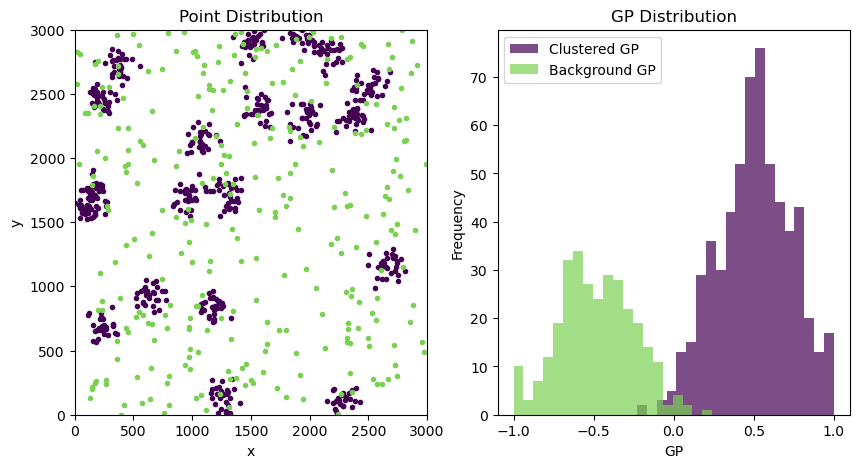

In [11]:
# Defining a base-case that will be used for all comparisons
 
n_clusters = 20
points_per_cluster = 30
std_deviation = 70
background_density = 0.5
plot_distribution = True
GP_mean_c = 0.5
GP_st_dev_c = 0.25
GP_mean_b = -0.5
GP_st_dev_b = 0.25

# generate the base-case
data_base = simulate_data(n_clusters, points_per_cluster, std_deviation, background_density, plot_distribution, GP_mean_c, GP_st_dev_c, GP_mean_b, GP_st_dev_b)

# Uncomment the below to make a DataFrame and save it to a CSV file
# data_base_df = pd.DataFrame(data_base, columns=['X', 'Y', 'GP'])
# data_base_df.to_csv('data_base.csv', index=False)

# Create a folder to store the plots if it doesn't exist
folder_name = 'Testing Method Figures'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Save the figure in the folder
plt.savefig(os.path.join(folder_name, 'base_case.png'))

# Test that the KS score is zero when comparing the base-case with itself
ks = gp_tot_ks_similarity(data_base,data_base)       
print(ks)   

##### Varying the Number of Clusters <a id="num-clusters_testing"></a>

[{0: (0.1811654280041273, 0.06777777777777778, 1.3485049107499327, 0.5324827055106126), 1: (0.13673519764923983, 0.14888888888888888, 1.369331241417889, 0.5516517759853393), 2: (0.079445681967498, 0.11444444444444445, 1.3641246587509013, 0.5193382617209479), 3: (0.3064089676608809, 0.1511111111111111, 1.379744406751864, 0.6124214951746186), 4: (0.4285173238270786, 0.16777777777777778, 1.3485049107499327, 0.6482666707849297), 5: (0.09741600017917502, 0.12, 1.3641246587509013, 0.5271802196433587), 6: (0.3180097028261225, 0.06555555555555556, 1.3537114934169203, 0.5790922505995328), 7: (0.11811799441660431, 0.08333333333333333, 1.379744406751864, 0.5270652448339339), 8: (0.3064089676608809, 0.14777777777777779, 1.3745378240848767, 0.609574856507845), 9: (0.3064089676608809, 0.10333333333333333, 1.3641246587509013, 0.5912889865817051), 10: (0.1811654280041273, 0.17888888888888888, 1.3901575720858395, 0.5834039629929518), 11: (0.05261088471215088, 0.10222222222222223, 1.3641246587509013, 0.

c:\Users\kms306\AppData\Local\anaconda3\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 44.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\kms306\AppData\Local\anaconda3\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 28.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\kms306\AppData\Local\anaconda3\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 21.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\kms306\AppData\Local\anaconda3\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 6.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\kms306\AppData\Local\anaconda3\Lib\s

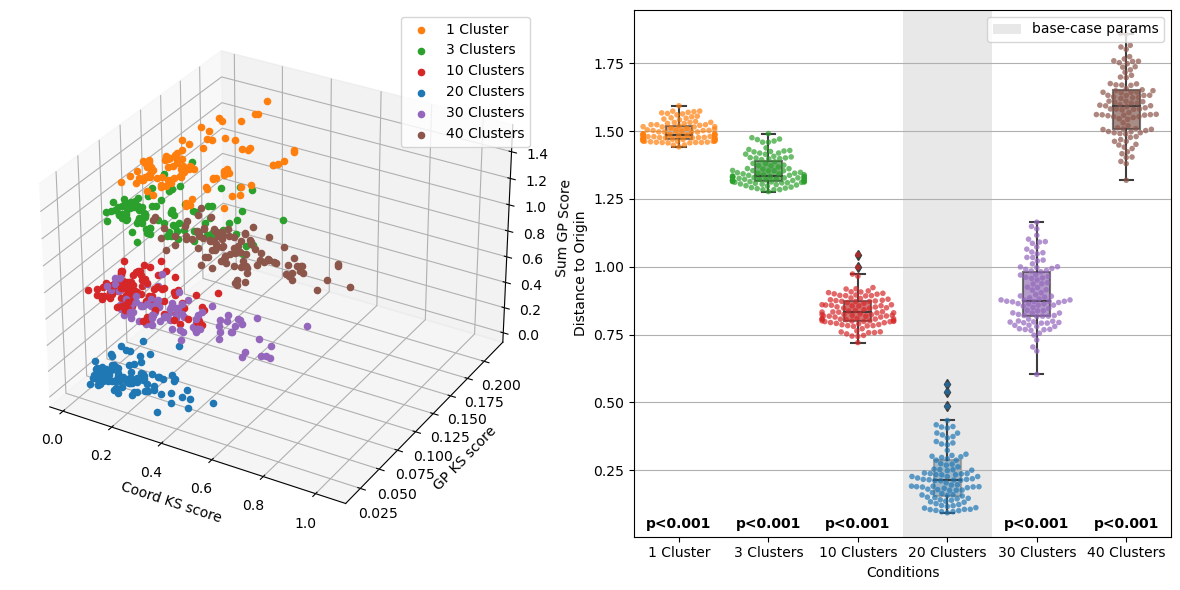

In [12]:
# Function to plot and store results for each condition
def plot_and_store_results(ax, condition_name, all_data, comparison_results, base_data):
    # Create a dictionary to store the results
    comparison_results_cond = {}
    num_datasets = len(all_data)

    # Define color for the condition
    condition_color = None
    if condition_name == '1 Cluster':
        condition_color = '#ff7f0e'
    elif condition_name == '3 Clusters':
        condition_color = '#2ca02c'
    elif condition_name == '10 Clusters':
        condition_color =  '#d62728'
    elif condition_name == '20 Clusters':
        condition_color = '#1f77b4'
    elif condition_name == '30 Clusters':
        condition_color = '#9467bd'
    elif condition_name == '40 Clusters':
        condition_color = '#8c564b'

    # Plot all datasets for the gp_tot_ks_similarity
    for i in range(num_datasets):
        dataset = all_data[i]

        # Call comparison function for the data in all_data with the base data
        # Using my method
        result = gp_tot_ks_similarity(base_data, dataset)

        # Plot the result in 3D space
        ax.scatter(result[0], result[1], result[2], marker='o', c=condition_color, label=condition_name if i == 0 else "")

        # Store result in dictionary
        comparison_results_cond[i] = result
    
    return comparison_results_cond


# Create figure to plot points in 3D space
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')

# Simulations for Condition 1 (1 cluster)
all_data_cond1 = [simulate_data(1, 30, 70, 0.5, False, 0.5, 0.25, -0.5, 0.25) for _ in range(100)]
#save_simulation_data('num_clusters_condition2', all_data_cond2)
comparison_results1 = plot_and_store_results(ax, '1 Cluster', all_data_cond1, {}, data_base)

# Simulations for Condition 2 (3 clusters)
all_data_cond2 = [simulate_data(3, 30, 70, 0.5, False, 0.5, 0.25, -0.5, 0.25) for _ in range(100)]
#save_simulation_data('num_clusters_condition3', all_data_cond3)
comparison_results2 = plot_and_store_results(ax, '3 Clusters', all_data_cond2, {}, data_base)

# Simulations for Condition 3 (10 clusters)
all_data_cond3 = [simulate_data(10, 30, 70, 0.5, False, 0.5, 0.25, -0.5, 0.25) for _ in range(100)]
#save_simulation_data('num_clusters_condition1', all_data_cond1)
comparison_results3 = plot_and_store_results(ax, '10 Clusters', all_data_cond3, {}, data_base)

# Simulations for Condition 4 (20 clusters) - same as base-case
all_data_cond4 = [simulate_data(20, 30, 70, 0.5, False, 0.5, 0.25, -0.5, 0.25) for _ in range(100)]
#save_simulation_data('num_clusters_condition4', all_data_cond4)
comparison_results4 = plot_and_store_results(ax, '20 Clusters', all_data_cond4, {}, data_base)

# Simulations for Condition 5 (30 clusters)
all_data_cond5 = [simulate_data(30, 30, 70, 0.5, False, 0.5, 0.25, -0.5, 0.25) for _ in range(100)]
#save_simulation_data('num_clusters_condition5', all_data_cond5)
comparison_results5 = plot_and_store_results(ax, '30 Clusters', all_data_cond5, {}, data_base)

# Simulations for Condition 6 (40 clusters)
all_data_cond6 = [simulate_data(40, 30, 70, 0.5, False, 0.5, 0.25, -0.5, 0.25) for _ in range(100)]
#save_simulation_data('num_clusters_condition6', all_data_cond6)
comparison_results6 = plot_and_store_results(ax, '40 Clusters', all_data_cond6, {}, data_base)

# Set axis labels
ax.set_xlabel('Coord KS score')
ax.set_ylabel('GP KS score')
ax.set_zlabel('Sum GP Score')

# Add legend
ax.legend()

#Extract data for each condition
data_conditions = [all_data_cond1, all_data_cond2, all_data_cond3, all_data_cond4, all_data_cond5, all_data_cond6]
data_comparison = [comparison_results1, comparison_results2, comparison_results3, comparison_results4, comparison_results5, comparison_results6]
print(data_comparison)
#Calculate distances for each point in each condition
distances = []
for comparison_result in data_comparison:
    condition_distances = []
    for i in range(len(comparison_result)):
        result = comparison_result[i]
        point_coords = np.array(result)
        distance = distance_to_origin(point_coords)
        condition_distances.append(distance)
    distances.append(condition_distances)
print(distances)

# # Compute p-values for each condition compared to 20 clusters
p_values_cond4_vs_others = perform_comparisons(distances, 100, 100, 3)
# p_values_cond4_vs_others = compute_p_values(distances, 3)  # 3 is the index of 20 Clusters

# Uncomment to print p-values
# for i, p_value in enumerate(p_values_cond4_vs_others):
#     print(f"P-value for Condition 4 vs Condition {i+1}:", p_value)
    
# Convert the distances to a DataFrame for plotting
df_distances = pd.DataFrame(distances).transpose()
condition_names = ['1 Cluster', '3 Clusters', '10 Clusters', '20 Clusters', '30 Clusters', '40 Clusters']
df_distances.columns = condition_names

# Plot the swarm plot with specified colors for each condition
colors = ['#ff7f0e', '#2ca02c', '#d62728', '#1f77b4', '#9467bd', '#8c564b']

# Plot swarm plot
ax1 = fig.add_subplot(122)
ax1.grid(axis='y')

# Swarm plot
sns.swarmplot(data=df_distances, palette=colors, size=4, alpha=0.7, ax=ax1)

# Overlay box plot (showing median and quartiles)
sns.boxplot(ax=ax1, data=df_distances, palette=colors, width=0.3, boxprops=dict(alpha=0.7))

for i, p in enumerate(p_values_cond4_vs_others):
    if i == 3:
        continue
    else:
        if p < 0.001:
            ax1.text(i, df_distances.min().min() * 0.4, f"p<{1e-3}", horizontalalignment='center', weight='bold')
        else:
            ax1.text(i, df_distances.min().min() * 0.4, f"p={p}", horizontalalignment='center', weight='bold')
    
# Find the index range for all_data_cond1
cond1_start = 2.5
cond1_end = 3.5

# Lightly shade the region behind all_data_cond1
ax1.axvspan(cond1_start, cond1_end, facecolor='lightgrey', alpha=0.5, label='base-case params')

# Set axis labels for swarm plot
ax1.set_xlabel('Conditions')
ax1.set_ylabel('Distance to Origin')
ax1.legend(loc = 'upper right')

# Remove the grey grid
#sns.set(style="whitegrid")
fig.tight_layout()

# Save the figure in the folder
plt.savefig(os.path.join(folder_name, 'num_clusters_plots.png'))
plt.show()

##### Varying the Number of Points per Cluster <a id="num-points-per-clusters_testing"></a>

In [ ]:
# Function to plot and store results for each condition

def plot_and_store_results(ax, condition_name, all_data, comparison_results, base_data):
    # Create a dictionary to store the results
    comparison_results_cond = {}
    num_datasets = len(all_data)

    # Define color for the condition
    condition_color = None
    if condition_name == '10 ppc':
        condition_color = '#ff7f0e'
    elif condition_name == '20 ppc':
        condition_color = '#2ca02c'
    elif condition_name == '30 ppc':
        condition_color = '#1f77b4'
    elif condition_name == '40 ppc':
        condition_color = '#d62728'
    elif condition_name == '50 ppc':
        condition_color = '#9467bd'
    elif condition_name == '100 ppc':
        condition_color = '#8c564b'

    # Plot all datasets for the gp_tot_ks_similarity
    for i in range(num_datasets):
        dataset = all_data[i]

        # Call comparison function for the data in all_data with the base data
        # Using my method
        result = gp_tot_ks_similarity(base_data, dataset)

        # Plot the result in 3D space
        ax.scatter(result[0], result[1], result[2], marker='o', c=condition_color, label=condition_name if i == 0 else "")

        # Store result in dictionary
        comparison_results_cond[i] = result
    
    return comparison_results_cond


# Create figure to plot points in 3D space
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')

# Simulations for Condition 1 
all_data_cond1 = [simulate_data(20, 10, 70, 0.5, False, 0.5, 0.25, -0.5, 0.25) for _ in range(100)]
#save_simulation_data('ppc_condition2', all_data_cond2)
comparison_results1 = plot_and_store_results(ax, '10 ppc', all_data_cond1, {}, data_base)

# Simulations for Condition 2 
all_data_cond2 = [simulate_data(20, 20, 70, 0.5, False, 0.5, 0.25, -0.5, 0.25) for _ in range(100)]
#save_simulation_data('ppc_condition1', all_data_cond1)
comparison_results2 = plot_and_store_results(ax, '20 ppc', all_data_cond2, {}, data_base)

# Simulations for Condition 3
all_data_cond3 = [simulate_data(20, 30, 70, 0.5, False, 0.5, 0.25, -0.5, 0.25) for _ in range(100)]
#save_simulation_data('ppc_condition3', all_data_cond3)
comparison_results3 = plot_and_store_results(ax, '30 ppc', all_data_cond3, {}, data_base)

# Simulations for Condition 4
all_data_cond4 = [simulate_data(20, 40, 70, 0.5, False, 0.5, 0.25, -0.5, 0.25) for _ in range(100)]
#save_simulation_data('ppc_condition4', all_data_cond4)
comparison_results4 = plot_and_store_results(ax, '40 ppc', all_data_cond4, {}, data_base)

# Simulations for Condition 5
all_data_cond5 = [simulate_data(10, 50, 70, 0.5, False, 0.5, 0.25, -0.5, 0.25) for _ in range(100)]
#save_simulation_data('ppc_condition5', all_data_cond5)
comparison_results5 = plot_and_store_results(ax, '50 ppc', all_data_cond5, {}, data_base)

# Simulations for Condition 6 
all_data_cond6 = [simulate_data(20, 100, 70, 0.5, False, 0.5, 0.25, -0.5, 0.25) for _ in range(100)]
#save_simulation_data('ppc_condition6', all_data_cond6)
comparison_results6 = plot_and_store_results(ax, '100 ppc', all_data_cond6, {}, data_base)

# Set axis labels
ax.set_xlabel('Coord KS score')
ax.set_ylabel('GP KS score')
ax.set_zlabel('Sum GP KS')

# Add legend
ax.legend()

# Extract data for each condition
data_conditions = [all_data_cond1, all_data_cond2, all_data_cond3, all_data_cond4, all_data_cond5, all_data_cond6]
data_comparison = [comparison_results1, comparison_results2, comparison_results3, comparison_results4, comparison_results5, comparison_results6]

#Calculate distances for each point in each condition
distances = []
for comparison_result in data_comparison:
    condition_distances = []
    for i in range(len(comparison_result)):
        result = comparison_result[i]
        point_coords = np.array(result)
        distance = distance_to_origin(point_coords)
        condition_distances.append(distance)
    distances.append(condition_distances)

print(distances)
# Compute p-values for each condition compared to 20 clusters
p_values_cond3_vs_others = perform_comparisons(distances, 100, 100, 2)

# Convert the distances to a DataFrame for plotting
df_distances = pd.DataFrame(distances).transpose()
condition_names = ['10 ppc', '20 ppc', '30 ppc','40 ppc','50 ppc', '100 ppc']
df_distances.columns = condition_names

# Plot the swarm plot with specified colors for each condition
colors = ['#ff7f0e', '#2ca02c', '#1f77b4', '#d62728', '#9467bd', '#8c564b']

# Plot swarm plot
ax1 = fig.add_subplot(122)
ax1.grid(axis='y')

# Swarm plot
sns.swarmplot(data=df_distances, palette=colors, size=4, alpha=0.7, ax=ax1)

# Overlay box plot (showing median and quartiles)
sns.boxplot(ax=ax1, data=df_distances, palette=colors, width=0.3, boxprops=dict(alpha=0.7))

for i, p in enumerate(p_values_cond3_vs_others):
    if i == 2:
        continue
    else:
        if p < 0.001:
            ax1.text(i, df_distances.min().min() * 0.4, f"p<{1e-3}", horizontalalignment='center', weight='bold')
        else:
            ax1.text(i, df_distances.min().min() * 0.4, f"p={p}", horizontalalignment='center', weight='bold')

# Find the index range for all_data_cond1
cond1_start = 1.5
cond1_end = 2.5

# Lightly shade the region behind all_data_cond1
ax1.axvspan(cond1_start, cond1_end, facecolor='lightgrey', alpha=0.5, label='Base-case params')

# Set axis labels for swarm plot
ax1.set_xlabel('Conditions')
ax1.set_ylabel('Distance to Origin')
ax1.legend(loc = 'upper left')
fig.tight_layout()

#saving the figure in the file 
plt.savefig(os.path.join(folder_name, 'ppc_plots.png'))
plt.show()

##### Varying the Standard Deviation of the Clusters <a id="std-clusters_testing"></a>

In [ ]:
# Function to plot and store results for each condition
def plot_and_store_results(ax, condition_name, all_data, comparison_results, base_data):
    # Create a dictionary to store the results
    comparison_results_cond = {}
    num_datasets = len(all_data)

    # Define color for the condition
    condition_color = None
    if condition_name == 'σ = 10':
        condition_color = '#ff7f0e'
    elif condition_name == 'σ = 40':
        condition_color = '#2ca02c'
    elif condition_name == 'σ = 70':
        condition_color = '#1f77b4'
    elif condition_name == 'σ = 100':
        condition_color = '#d62728'
    elif condition_name == 'σ = 150':
        condition_color = '#9467bd'
    elif condition_name == 'σ = 200':
        condition_color = '#8c564b'

    # Plot all datasets for the gp_tot_ks_similarity
    for i in range(num_datasets):
        dataset = all_data[i]

        # Call comparison function for the data in all_data with the base data
        # Using my method
        result = gp_tot_ks_similarity(base_data, dataset)

        # Plot the result in 3D space
        ax.scatter(result[0], result[1], result[2], marker='o', c=condition_color, label=condition_name if i == 0 else "")

        # Store result in dictionary
        comparison_results_cond[i] = result
    
    return comparison_results_cond


# Create figure to plot points in 3D space
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')

# Simulations for Condition 1
all_data_cond1 = [simulate_data(20, 30, 10, 0.5, False, 0.5, 0.25, -0.5, 0.25) for _ in range(100)]
#save_simulation_data('ppc_condition2', all_data_cond2)
comparison_results1 = plot_and_store_results(ax, 'σ = 10', all_data_cond1, {}, data_base)

# Simulations for Condition 2
all_data_cond2 = [simulate_data(20, 30, 40, 0.5, False, 0.5, 0.25, -0.5, 0.25) for _ in range(100)]
#save_simulation_data('ppc_condition1', all_data_cond1)
comparison_results2 = plot_and_store_results(ax, 'σ = 40', all_data_cond2, {}, data_base)

# Simulations for Condition 3
all_data_cond3 = [simulate_data(20, 30, 70, 0.5, False, 0.5, 0.25, -0.5, 0.25) for _ in range(100)]
#save_simulation_data('ppc_condition3', all_data_cond3)
comparison_results3 = plot_and_store_results(ax, 'σ = 70', all_data_cond3, {}, data_base)

# Simulations for Condition 4
all_data_cond4 = [simulate_data(20, 30, 100, 0.5, False, 0.5, 0.25, -0.5, 0.25) for _ in range(100)]
#save_simulation_data('ppc_condition4', all_data_cond4)
comparison_results4 = plot_and_store_results(ax, 'σ = 100', all_data_cond4, {}, data_base)

# Simulations for Condition 5
all_data_cond5 = [simulate_data(20, 30, 150, 0.5, False, 0.5, 0.25, -0.5, 0.25) for _ in range(100)]
#save_simulation_data('ppc_condition5', all_data_cond5)
comparison_results5 = plot_and_store_results(ax, 'σ = 150', all_data_cond5, {}, data_base)

# Simulations for Condition 6
all_data_cond6 = [simulate_data(20, 30, 200, 0.5, False, 0.5, 0.25, -0.5, 0.25) for _ in range(100)]
#save_simulation_data('ppc_condition6', all_data_cond6)
comparison_results6 = plot_and_store_results(ax, 'σ = 200', all_data_cond6, {}, data_base)

# Set axis labels
ax.set_xlabel('Coord KS score')
ax.set_ylabel('GP KS score')
ax.set_zlabel('Sum GP score')

# Add legend
ax.legend()

# Extract data for each condition
data_conditions = [all_data_cond1, all_data_cond2, all_data_cond3, all_data_cond4, all_data_cond5, all_data_cond6]
data_comparison = [comparison_results1, comparison_results2, comparison_results3, comparison_results4, comparison_results5, comparison_results6]

#Calculate distances for each point in each condition
distances = []
for comparison_result in data_comparison:
    condition_distances = []
    for i in range(len(comparison_result)):
        result = comparison_result[i]
        point_coords = np.array(result)
        distance = distance_to_origin(point_coords)
        condition_distances.append(distance)
    distances.append(condition_distances)

# Compute p-values for each condition compared base case
p_values_cond3_vs_others = perform_comparisons(distances, 100, 100, 2)

# Convert the distances to a DataFrame for plotting
df_distances = pd.DataFrame(distances).transpose()
condition_names = ['σ = 10', 'σ = 40','σ = 70','σ = 100', 'σ = 150', 'σ = 200']
df_distances.columns = condition_names

# Plot the swarm plot with specified colors for each condition
colors = ['#ff7f0e', '#2ca02c', '#1f77b4', '#d62728', '#9467bd', '#8c564b']

# Plot swarm plot
ax1 = fig.add_subplot(122)
ax1.grid(axis='y')

# Swarm plot
sns.swarmplot(data=df_distances, palette=colors, size=4, alpha=0.7, ax=ax1)

# Overlay box plot (showing median and quartiles)
sns.boxplot(ax=ax1, data=df_distances, palette=colors, width=0.3, boxprops=dict(alpha=0.7))

for i, p in enumerate(p_values_cond3_vs_others):
    if i == 2:
        continue
    else:
        if p < 0.001:
            ax1.text(i, df_distances.min().min() * 0.3, f"p<{1e-3}", horizontalalignment='center', weight='bold')
        else:
            ax1.text(i, df_distances.min().min() * 0.3, f"p={p}", horizontalalignment='center', weight='bold')
    
# Find the index range for all_data_cond1
cond1_start = 1.5
cond1_end = 2.5

# Lightly shade the region behind all_data_cond1
ax1.axvspan(cond1_start, cond1_end, facecolor='lightgrey', alpha=0.5, label='Base-case params')

# Set axis labels for swarm plot
ax1.set_xlabel('Conditions')
ax1.set_ylabel('Distance to Origin')
ax1.legend(loc = 'upper right')

# Display the plots
#fig.suptitle('Comparing Datasets with Varying Numbers of Points per Cluster', fontsize=16)

fig.tight_layout()

#saving the figure in the file
plt.savefig(os.path.join(folder_name, 'cluster_spread_plots.png'))
plt.show()

##### Varying the Density of Background Points <a id="background-density_testing"></a>

In [ ]:
# Function to plot and store results for each condition
def plot_and_store_results(ax, condition_name, all_data, comparison_results, base_data):
    # Create a dictionary to store the results
    comparison_results_cond = {}
    num_datasets = len(all_data)

    # Define color for the condition
    condition_color = None
    if condition_name == 'B-Density 0.1':
        condition_color = '#ff7f0e'
    elif condition_name == 'B-Density 0.3':
        condition_color = '#2ca02c'
    elif condition_name == 'B-Density 0.5':
        condition_color = '#1f77b4'
    elif condition_name == 'B-Density 0.7':
        condition_color = '#d62728'
    elif condition_name == 'B-Density 0.9':
        condition_color = '#9467bd'
    elif condition_name == 'B-Density 1.0':
        condition_color = '#8c564b'

    # Plot all datasets for the gp_tot_ks_similarity
    for i in range(num_datasets):
        dataset = all_data[i]

        # Call comparison function for the data in all_data with the base data
        # Using my method
        result = gp_tot_ks_similarity(base_data, dataset)

        # Plot the result in 3D space
        ax.scatter(result[0], result[1], result[2], marker='o', c=condition_color, label=condition_name if i == 0 else "")

        # Store result in dictionary
        comparison_results_cond[i] = result
    
    return comparison_results_cond


# Create figure to plot points in 3D space
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')

# Simulations for Condition 1
all_data_cond1 = [simulate_data(20, 30, 70, 0.1, False, 0.5, 0.25, -0.5, 0.25) for _ in range(100)]
#save_simulation_data('ppc_condition2', all_data_cond2)
comparison_results1 = plot_and_store_results(ax, 'B-Density 0.1', all_data_cond1, {}, data_base)

# Simulations for Condition 2
all_data_cond2 = [simulate_data(20, 30, 70, 0.3, False, 0.5, 0.25, -0.5, 0.25) for _ in range(100)]
#save_simulation_data('ppc_condition1', all_data_cond1)
comparison_results2 = plot_and_store_results(ax, 'B-Density 0.3', all_data_cond2, {}, data_base)

# Simulations for Condition 3
all_data_cond3 = [simulate_data(20, 30, 70, 0.5, False, 0.5, 0.25, -0.5, 0.25) for _ in range(100)]
#save_simulation_data('ppc_condition3', all_data_cond3)
comparison_results3 = plot_and_store_results(ax, 'B-Density 0.5', all_data_cond3, {}, data_base)

# Simulations for Condition 4 
all_data_cond4 = [simulate_data(20, 30, 70, 0.7, False, 0.5, 0.25, -0.5, 0.25) for _ in range(100)]
#save_simulation_data('ppc_condition4', all_data_cond4)
comparison_results4 = plot_and_store_results(ax, 'B-Density 0.7', all_data_cond4, {}, data_base)

# Simulations for Condition 5 
all_data_cond5 = [simulate_data(20, 30, 70, 0.9, False, 0.5, 0.25, -0.5, 0.25) for _ in range(100)]
#save_simulation_data('ppc_condition5', all_data_cond5)
comparison_results5 = plot_and_store_results(ax, 'B-Density 0.9', all_data_cond5, {}, data_base)

# Simulations for Condition 6 
all_data_cond6 = [simulate_data(20, 30, 70, 1.0, False, 0.5, 0.25, -0.5, 0.25) for _ in range(100)]
#save_simulation_data('ppc_condition6', all_data_cond6)
comparison_results6 = plot_and_store_results(ax, 'B-Density 1.0', all_data_cond6, {}, data_base)

# Set axis labels
ax.set_xlabel('Coord KS score')
ax.set_ylabel('GP KS score')
ax.set_zlabel('Sum GP score')

# Add legend
ax.legend()

# Extract data for each condition
data_conditions = [all_data_cond1, all_data_cond2, all_data_cond3, all_data_cond4, all_data_cond5, all_data_cond6]
data_comparison = [comparison_results1, comparison_results2, comparison_results3, comparison_results4, comparison_results5, comparison_results6]

#Calculate distances for each point in each condition
distances = []
for comparison_result in data_comparison:
    condition_distances = []
    for i in range(len(comparison_result)):
        result = comparison_result[i]
        point_coords = np.array(result)
        distance = distance_to_origin(point_coords)
        condition_distances.append(distance)
    distances.append(condition_distances)

# Convert the distances to a DataFrame for plotting
df_distances = pd.DataFrame(distances).transpose()
condition_names = ['density 0.1', 'density 0.3','density 0.5','density 0.7', 'density 0.9', 'density 1.0']
df_distances.columns = condition_names

# Compute p-values for each condition compared to background density 0.5
p_values_cond3_vs_others = perform_comparisons(distances, 100, 100, 2)

# Plot the swarm plot with specified colors for each condition
colors = ['#ff7f0e', '#2ca02c', '#1f77b4', '#d62728', '#9467bd', '#8c564b']

# Plot swarm plot
ax1 = fig.add_subplot(122)
ax1.grid(axis='y')

# Swarm plot
sns.swarmplot(data=df_distances, palette=colors, size=4, alpha=0.7, ax=ax1)

# Overlay box plot (showing median and quartiles)
sns.boxplot(ax=ax1, data=df_distances, palette=colors, width=0.3, boxprops=dict(alpha=0.7))

# Add p-values as annotations under each box plot
for i, p in enumerate(p_values_cond3_vs_others):
    if i == 2:
        continue
    else:
        if p < 0.001:
            ax1.text(i, df_distances.min().min() * 0.4, f"p<{1e-3}", horizontalalignment='center', weight='bold')
        else:
            ax1.text(i, df_distances.min().min() * 0.4, f"p={p}", horizontalalignment='center', weight='bold')
    
# Find the index range for all_data_cond1
cond1_start = 1.5
cond1_end = 2.5

# Lightly shade the region behind all_data_cond1
ax1.axvspan(cond1_start, cond1_end, facecolor='lightgrey', alpha=0.5, label='Base-case params')

# Set axis labels for swarm plot
ax1.set_xlabel('Conditions')
ax1.set_ylabel('Distance to Origin')
ax1.legend(loc = 'upper left')
fig.tight_layout()

#saving the figure in the file
plt.savefig(os.path.join(folder_name, 'background_density_pots.png'))
plt.show()


##### Varying the Difference in GP Distribution Means About Zero <a id="GP-mean-1_testing"></a>

In [ ]:
# Function to plot and store results for each condition
def plot_and_store_results(ax, condition_name, all_data, comparison_results, base_data):
    # Create a dictionary to store the results
    comparison_results_cond = {}
    num_datasets = len(all_data)

    # Define color for the condition
    condition_color = None
    if condition_name == 'Mean diff 0.2':
        condition_color = '#ff7f0e'
    elif condition_name == 'Mean diff 0.5':
        condition_color = '#2ca02c'
    elif condition_name == 'Mean diff 0.8':
        condition_color = '#d62728'
    elif condition_name == 'Mean diff 1.0':
        condition_color = '#1f77b4'
    elif condition_name == 'Mean diff 1.2':
        condition_color = '#9467bd'
#     elif condition_name == 'Mean diff 1.5':
#         condition_color = '#8c564b'

    # Plot all datasets for the gp_tot_ks_similarity
    for i in range(num_datasets):
        dataset = all_data[i]

        # Call comparison function for the data in all_data with the base data
        # Using my method
        result = gp_tot_ks_similarity(base_data, dataset)

        # Plot the result in 3D space'#1f77b4'
        ax.scatter(result[0], result[1], result[2], marker='o', c=condition_color, label=condition_name if i == 0 else "")

        # Store result in dictionary
        comparison_results_cond[i] = result
    
    return comparison_results_cond


# Create figure to plot points in 3D space
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')

# Simulations for Condition 1
all_data_cond1 = [simulate_data(20, 30, 70, 0.5, False, 0.1, 0.25, -0.1, 0.25) for _ in range(100)]
#save_simulation_data('ppc_condition2', all_data_cond2)
comparison_results1 = plot_and_store_results(ax, 'Mean diff 0.2', all_data_cond1, {}, data_base)

# Simulations for Condition 2
all_data_cond2 = [simulate_data(20, 30, 70, 0.5, False, 0.25, 0.25, -0.25, 0.25) for _ in range(100)]
#save_simulation_data('ppc_condition1', all_data_cond1)
comparison_results2 = plot_and_store_results(ax, 'Mean diff 0.5', all_data_cond2, {}, data_base)

# Simulations for Condition 3
all_data_cond3 = [simulate_data(20, 30, 70, 0.5, False, 0.4, 0.25, -0.4, 0.25) for _ in range(100)]
#save_simulation_data('ppc_condition3', all_data_cond3)
comparison_results3 = plot_and_store_results(ax, 'Mean diff 0.8', all_data_cond3, {}, data_base)

# Simulations for Condition 4 (20 clusters)
all_data_cond4 = [simulate_data(20, 30, 70, 0.5, False, 0.5, 0.25, -0.5, 0.25) for _ in range(100)]
#save_simulation_data('ppc_condition4', all_data_cond4)
comparison_results4 = plot_and_store_results(ax, 'Mean diff 1.0', all_data_cond4, {}, data_base)

# Simulations for Condition 5 (30 clusters)
all_data_cond5 = [simulate_data(20, 30, 70, 0.5, False, 0.6, 0.25, -0.6, 0.25) for _ in range(100)]
#save_simulation_data('ppc_condition5', all_data_cond5)
comparison_results5 = plot_and_store_results(ax, 'Mean diff 1.2', all_data_cond5, {}, data_base)

# Set axis labels
ax.set_xlabel('Coord KS score')
ax.set_ylabel('GP KS score')
ax.set_zlabel('Sum GP score')
# Add legend
ax.legend()

# Extract data for each condition
data_conditions = [all_data_cond1, all_data_cond2, all_data_cond3, all_data_cond4, all_data_cond5]
data_comparison = [comparison_results1, comparison_results2, comparison_results3, comparison_results4, comparison_results5]

#Calculate distances for each point in each condition
distances = []
for comparison_result in data_comparison:
    condition_distances = []
    for i in range(len(comparison_result)):
        result = comparison_result[i]
        point_coords = np.array(result)
        distance = distance_to_origin(point_coords)
        condition_distances.append(distance)
    distances.append(condition_distances)

# Convert the distances to a DataFrame for plotting
df_distances = pd.DataFrame(distances).transpose()
condition_names = ['Mean diff 0.2', 'Mean diff 0.5','Mean diff 0.8','Mean diff 1', 'Mean diff 1.2']
df_distances.columns = condition_names

# Compute p-values for each condition compared to mean diff 1
p_values_cond4_vs_others = perform_comparisons(distances, 100, 100, 3)

# Plot the swarm plot with specified colors for each condition
colors = ['#ff7f0e', '#2ca02c', '#d62728', '#1f77b4', '#9467bd', '#8c564b']

# Plot swarm plot
ax1 = fig.add_subplot(122)
ax1.grid(axis='y')

# Swarm plot
sns.swarmplot(data=df_distances, palette=colors, size=4, alpha=0.7, ax=ax1)

# Overlay box plot (showing median and quartiles)
sns.boxplot(ax=ax1, data=df_distances, palette=colors, width=0.3, boxprops=dict(alpha=0.7))

# Add p-values as annotations under each box plot
for i, p in enumerate(p_values_cond4_vs_others):
    if i == 3:
        continue
    else:
        if p < 0.001:
            ax1.text(i, df_distances.min().min() * 0.4, f"p<{1e-3}", horizontalalignment='center', weight='bold')
        else:
            ax1.text(i, df_distances.min().min() * 0.4, f"p={p}", horizontalalignment='center', weight='bold')
    
# Find the index range for all_data_cond1
cond1_start = 2.5
cond1_end = 3.5

# Lightly shade the region behind all_data_cond1
ax1.axvspan(cond1_start, cond1_end, facecolor='lightgrey', alpha=0.5, label='Base-case params')

# Set axis labels for swarm plot
ax1.set_xlabel('Conditions')
ax1.set_ylabel('Distance to Origin')
ax1.legend(loc = 'upper right')
fig.tight_layout()

#saving the figure in the file
plt.savefig(os.path.join(folder_name, 'Mean_GP_diff_plots1.png'))
plt.show()

##### Varying the Difference in GP Distribution Means with Fixed Clustered GP Distribution Mean <a id="GP-mean-2_testing"></a>

In [ ]:
# Function to plot and store results for each condition
def plot_and_store_results(ax, condition_name, all_data, comparison_results, base_data):
    # Create a dictionary to store the results
    comparison_results_cond = {}
    num_datasets = len(all_data)

    # Define color for the condition
    condition_color = None
    if condition_name == 'Mean diff 0.2':
        condition_color = '#ff7f0e'
    elif condition_name == 'Mean diff 0.5':
        condition_color = '#2ca02c'
    elif condition_name == 'Mean diff 0.8':
        condition_color = '#d62728'
    elif condition_name == 'Mean diff 1.0':
        condition_color = '#1f77b4'
    elif condition_name == 'Mean diff 1.2':
        condition_color = '#9467bd'

    # Plot all datasets for the gp_tot_ks_similarity
    for i in range(num_datasets):
        dataset = all_data[i]

        # Call comparison function for the data in all_data with the base data
        # Using my method
        result = gp_tot_ks_similarity(base_data, dataset)

        # Plot the result in 3D space'#1f77b4'
        ax.scatter(result[0], result[1], result[2], marker='o', c=condition_color, label=condition_name if i == 0 else "")

        # Store result in dictionary
        comparison_results_cond[i] = result
    
    return comparison_results_cond


# Create figure to plot points in 3D space
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')

# Simulations for Condition 1
all_data_cond1 = [simulate_data(20, 30, 70, 0.5, False, 0.5, 0.25, 0.3, 0.25) for _ in range(100)]
#save_simulation_data('ppc_condition2', all_data_cond2)
comparison_results1 = plot_and_store_results(ax, 'Mean diff 0.2', all_data_cond1, {}, data_base)

# Simulations for Condition 2
all_data_cond2 = [simulate_data(20, 30, 70, 0.5, False, 0.5, 0.25, 0.0, 0.25) for _ in range(100)]
#save_simulation_data('ppc_condition1', all_data_cond1)
comparison_results2 = plot_and_store_results(ax, 'Mean diff 0.5', all_data_cond2, {}, data_base)

# Simulations for Condition 3
all_data_cond3 = [simulate_data(20, 30, 70, 0.5, False, 0.5, 0.25, -0.3, 0.25) for _ in range(100)]
#save_simulation_data('ppc_condition3', all_data_cond3)
comparison_results3 = plot_and_store_results(ax, 'Mean diff 0.8', all_data_cond3, {}, data_base)

# Simulations for Condition 4 
all_data_cond4 = [simulate_data(20, 30, 70, 0.5, False, 0.5, 0.25, -0.5, 0.25) for _ in range(100)]
#save_simulation_data('ppc_condition4', all_data_cond4)
comparison_results4 = plot_and_store_results(ax, 'Mean diff 1.0', all_data_cond4, {}, data_base)

# Simulations for Condition 5 
all_data_cond5 = [simulate_data(20, 30, 70, 0.5, False, 0.5, 0.25, -0.7, 0.25) for _ in range(100)]
#save_simulation_data('ppc_condition5', all_data_cond5)
comparison_results5 = plot_and_store_results(ax, 'Mean diff 1.2', all_data_cond5, {}, data_base)


# Set axis labels
ax.set_xlabel('Coord KS score')
ax.set_ylabel('GP KS score')
ax.set_zlabel('Sum GP score')
# Add legend
ax.legend()

# Extract data for each condition
data_conditions = [all_data_cond1, all_data_cond2, all_data_cond3, all_data_cond4, all_data_cond5]
data_comparison = [comparison_results1, comparison_results2, comparison_results3, comparison_results4, comparison_results5]

#Calculate distances for each point in each condition
distances = []
for comparison_result in data_comparison:
    condition_distances = []
    for i in range(len(comparison_result)):
        result = comparison_result[i]
        point_coords = np.array(result)
        distance = distance_to_origin(point_coords)
        condition_distances.append(distance)
    distances.append(condition_distances)

# Compute p-values for each condition compared to mean diff 1
p_values_cond4_vs_others = perform_comparisons(distances, 100, 100, 3)

# Convert the distances to a DataFrame for plotting
df_distances = pd.DataFrame(distances).transpose()
condition_names = ['Mean diff 0.2', 'Mean diff 0.5','Mean diff 0.8','Mean diff 1', 'Mean diff 1.2']
df_distances.columns = condition_names

# Plot the swarm plot with specified colors for each condition
colors = ['#ff7f0e', '#2ca02c', '#d62728', '#1f77b4', '#9467bd']

# Plot swarm plot
ax1 = fig.add_subplot(122)
ax1.grid(axis='y')

# Swarm plot
sns.swarmplot(data=df_distances, palette=colors, size=4, alpha=0.7, ax=ax1)

# Overlay box plot (showing median and quartiles)
sns.boxplot(ax=ax1, data=df_distances, palette=colors, width=0.3, boxprops=dict(alpha=0.7))

# Add p-values as annotations under each box plot
for i, p in enumerate(p_values_cond4_vs_others):
    if i == 3:
        continue
    else:
        if p < 0.001:
            ax1.text(i, df_distances.min().min() * 0.4, f"p<{1e-3}", horizontalalignment='center', weight='bold')
        else:
            ax1.text(i, df_distances.min().min() * 0.4, f"p={p}", horizontalalignment='center', weight='bold')

# Find the index range for all_data_cond1
cond1_start = 2.5
cond1_end = 3.5

# Lightly shade the region behind all_data_cond1
ax1.axvspan(cond1_start, cond1_end, facecolor='lightgrey', alpha=0.5, label='Base-case params')

# Set axis labels for swarm plot
ax1.set_xlabel('Conditions')
ax1.set_ylabel('Distance to Origin')
ax1.legend(loc = 'upper right')
fig.tight_layout()

#saving the figure in the file
plt.savefig(os.path.join(folder_name, 'Mean_GP_diff_plots2.png'))

plt.show()

##### Varying the Difference in GP Distribution Means with Fixed Background GP Distribution Mean <a id="GP-mean-3_testing"></a>

In [ ]:
# Function to plot and store results for each condition
def plot_and_store_results(ax, condition_name, all_data, comparison_results, base_data):
    # Create a dictionary to store the results
    comparison_results_cond = {}
    num_datasets = len(all_data)

    # Define color for the condition
    condition_color = None
    if condition_name == 'Mean diff 0.2':
        condition_color = '#ff7f0e'
    elif condition_name == 'Mean diff 0.5':
        condition_color = '#2ca02c'
    elif condition_name == 'Mean diff 0.8':
        condition_color = '#d62728'
    elif condition_name == 'Mean diff 1.0':
        condition_color = '#1f77b4'
    elif condition_name == 'Mean diff 1.2':
        condition_color = '#9467bd'

    # Plot all datasets for the gp_tot_ks_similarity
    for i in range(num_datasets):
        dataset = all_data[i]

        # Call comparison function for the data in all_data with the base data
        # Using my method
        result = gp_tot_ks_similarity(base_data, dataset)

        # Plot the result in 3D space'#1f77b4'
        ax.scatter(result[0], result[1], result[2], marker='o', c=condition_color, label=condition_name if i == 0 else "")

        # Store result in dictionary
        comparison_results_cond[i] = result
    
    return comparison_results_cond


# Create figure to plot points in 3D space
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')

# Simulations for Condition 1
all_data_cond1 = [simulate_data(20, 30, 70, 0.5, False, -0.3, 0.25, -0.5, 0.25) for _ in range(100)]
#save_simulation_data('ppc_condition2', all_data_cond2)
comparison_results1 = plot_and_store_results(ax, 'Mean diff 0.2', all_data_cond1, {}, data_base)

# Simulations for Condition 2
all_data_cond2 = [simulate_data(20, 30, 70, 0.5, False, 0.0, 0.25, -0.5, 0.25) for _ in range(100)]
#save_simulation_data('ppc_condition1', all_data_cond1)
comparison_results2 = plot_and_store_results(ax, 'Mean diff 0.5', all_data_cond2, {}, data_base)

# Simulations for Condition 3
all_data_cond3 = [simulate_data(20, 30, 70, 0.5, False, 0.3, 0.25, -0.5, 0.25) for _ in range(100)]
#save_simulation_data('ppc_condition3', all_data_cond3)
comparison_results3 = plot_and_store_results(ax, 'Mean diff 0.8', all_data_cond3, {}, data_base)

# Simulations for Condition 4
all_data_cond4 = [simulate_data(20, 30, 70, 0.5, False, 0.5, 0.25, -0.5, 0.25) for _ in range(100)]
#save_simulation_data('ppc_condition4', all_data_cond4)
comparison_results4 = plot_and_store_results(ax, 'Mean diff 1.0', all_data_cond4, {}, data_base)

# Simulations for Condition 5
all_data_cond5 = [simulate_data(20, 30, 70, 0.5, False, 0.7, 0.25, -0.5, 0.25) for _ in range(100)]
#save_simulation_data('ppc_condition5', all_data_cond5)
comparison_results5 = plot_and_store_results(ax, 'Mean diff 1.2', all_data_cond5, {}, data_base)


# Set axis labels
ax.set_xlabel('Coord KS score')
ax.set_ylabel('GP KS score')
ax.set_zlabel('Sum GP score')
# Add legend
ax.legend()

# Extract data for each condition
data_conditions = [all_data_cond1, all_data_cond2, all_data_cond3, all_data_cond4, all_data_cond5]
data_comparison = [comparison_results1, comparison_results2, comparison_results3, comparison_results4, comparison_results5]

#Calculate distances for each point in each condition
distances = []
for comparison_result in data_comparison:
    condition_distances = []
    for i in range(len(comparison_result)):
        result = comparison_result[i]
        point_coords = np.array(result)
        distance = distance_to_origin(point_coords)
        condition_distances.append(distance)
    distances.append(condition_distances)

# Compute p-values for each condition compared to mean diff 1
p_values_cond4_vs_others = perform_comparisons(distances, 100, 100, 3)

# Convert the distances to a DataFrame for plotting
df_distances = pd.DataFrame(distances).transpose()
condition_names = ['Mean diff 0.2', 'Mean diff 0.5','Mean diff 0.8','Mean diff 1', 'Mean diff 1.2']
df_distances.columns = condition_names


# Plot the swarm plot with specified colors for each condition
colors = ['#ff7f0e', '#2ca02c', '#d62728', '#1f77b4', '#9467bd']

# Plot swarm plot
ax1 = fig.add_subplot(122)
ax1.grid(axis='y')

# Swarm plot
sns.swarmplot(data=df_distances, palette=colors, size=4, alpha=0.7, ax=ax1)

# Overlay box plot (showing median and quartiles)
sns.boxplot(ax=ax1, data=df_distances, palette=colors, width=0.3, boxprops=dict(alpha=0.7))

# Add p-values as annotations under each box plot
for i, p in enumerate(p_values_cond4_vs_others):
    if i == 3:
        continue
    else:
        if p < 0.001:
            ax1.text(i, df_distances.min().min() * 0.4, f"p<{1e-3}", horizontalalignment='center', weight='bold')
        else:
            ax1.text(i, df_distances.min().min() * 0.4, f"p={p}", horizontalalignment='center', weight='bold')

# Find the index range for all_data_cond1
cond1_start = 2.5
cond1_end = 3.5

# Lightly shade the region behind all_data_cond1
ax1.axvspan(cond1_start, cond1_end, facecolor='lightgrey', alpha=0.5, label='Base-case params')

# Set axis labels for swarm plot
ax1.set_xlabel('Conditions')
ax1.set_ylabel('Distance to Origin')
ax1.legend(loc = 'upper right')
fig.tight_layout()

#saving the figure in the file
plt.savefig(os.path.join(folder_name, 'Mean_GP_diff_plots3.png'))

plt.show()

##### Varying the GP distribution standard deviation <a id="GP-std_testing"></a>

In [ ]:
# Function to plot and store results for each condition
def plot_and_store_results(ax, condition_name, all_data, comparison_results, base_data):
    # Create a dictionary to store the results
    comparison_results_cond = {}
    num_datasets = len(all_data)

    # Define color for the condition
    condition_color = None
    if condition_name == r'$\sigma_{GP} = 0.1$':
        condition_color = '#ff7f0e' 
    elif condition_name == r'$\sigma_{GP} = 0.25$':
        condition_color = '#1f77b4'
    elif condition_name == r'$\sigma_{GP} = 0.4$':
        condition_color = '#2ca02c'
    elif condition_name == r'$\sigma_{GP} = 0.5$':
        condition_color =  '#d62728'
    elif condition_name == r'$\sigma_{GP} = 0.75$':
        condition_color = '#9467bd'

    # Plot all datasets for the gp_tot_ks_similarity
    for i in range(num_datasets):
        dataset = all_data[i]

        # Call comparison function for the data in all_data with the base data
        # Using my method
        result = gp_tot_ks_similarity(base_data, dataset)

        # Plot the result in 3D space
        ax.scatter(result[0], result[1], result[2], marker='o', c=condition_color, label=condition_name if i == 0 else "")

        # Store result in dictionary
        comparison_results_cond[i] = result
    
    return comparison_results_cond


# Create figure to plot points in 3D space
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')

# Simulations for Condition 1
all_data_cond1 = [simulate_data(20, 30, 70, 0.5, False, 0.5, 0.1, -0.5, 0.1) for _ in range(100)]
#save_simulation_data('ppc_condition2', all_data_cond2)
comparison_results1 = plot_and_store_results(ax, r'$\sigma_{GP} = 0.1$', all_data_cond1, {}, data_base)

# Simulations for Condition 2
all_data_cond2 = [simulate_data(20, 30, 70, 0.5, False, 0.5 , 0.25, -0.5, 0.25) for _ in range(100)]
#save_simulation_data('ppc_condition1', all_data_cond1)
comparison_results2 = plot_and_store_results(ax, r'$\sigma_{GP} = 0.25$', all_data_cond2, {}, data_base)

# Simulations for Condition 3
all_data_cond3 = [simulate_data(20, 30, 70, 0.5, False, 0.5, 0.4, -0.5, 0.4) for _ in range(100)]
#save_simulation_data('ppc_condition3', all_data_cond3)
comparison_results3 = plot_and_store_results(ax, r'$\sigma_{GP} = 0.4$', all_data_cond3, {}, data_base)

# Simulations for Condition 4 
all_data_cond4 = [simulate_data(20, 30, 70, 0.5, False, 0.5, 0.5, -0.5, 0.5) for _ in range(100)]
#save_simulation_data('ppc_condition4', all_data_cond4)
comparison_results4 = plot_and_store_results(ax, r'$\sigma_{GP} = 0.5$', all_data_cond4, {}, data_base)

# Simulations for Condition 5 
all_data_cond5 = [simulate_data(20, 30, 70, 0.5, False, 0.5, 0.75, -0.5, 0.75) for _ in range(100)]
#save_simulation_data('ppc_condition5', all_data_cond5)
comparison_results5 = plot_and_store_results(ax, r'$\sigma_{GP} = 0.75$', all_data_cond5, {}, data_base)


# Set axis labels
ax.set_xlabel('Coord KS score')
ax.set_ylabel('GP KS score')
ax.set_zlabel('Sum GP score')
# Add legend
ax.legend()

# Extract data for each condition
data_conditions = [all_data_cond1, all_data_cond2, all_data_cond3, all_data_cond4, all_data_cond5]
data_comparison = [comparison_results1, comparison_results2, comparison_results3, comparison_results4, comparison_results5]

#Calculate distances for each point in each condition
distances = []
for comparison_result in data_comparison:
    condition_distances = []
    for i in range(len(comparison_result)):
        result = comparison_result[i]
        point_coords = np.array(result)
        distance = distance_to_origin(point_coords)
        condition_distances.append(distance)
    distances.append(condition_distances)

# Compute p-values for each condition compared to gp std dev 0.25
p_values_cond2_vs_others = perform_comparisons(distances, 100, 100, 1)

# Convert the distances to a DataFrame for plotting
df_distances = pd.DataFrame(distances).transpose()
condition_names = [r'$\sigma_{GP} = 0.1$', r'$\sigma_{GP} = 0.25$', r'$\sigma_{GP} = 0.4$', r'$\sigma_{GP} = 0.5$', r'$\sigma_{GP} = 0.75$']
df_distances.columns = condition_names


# Plot the swarm plot with specified colors for each condition
colors = ['#ff7f0e', '#1f77b4', '#2ca02c', '#d62728', '#9467bd']

# Plot swarm plot
ax1 = fig.add_subplot(122)
ax1.grid(axis='y')

# Swarm plot
sns.swarmplot(data=df_distances, palette=colors, size=4, alpha=0.7, ax=ax1)

# Overlay box plot (showing median and quartiles)
sns.boxplot(ax=ax1, data=df_distances, palette=colors, width=0.3, boxprops=dict(alpha=0.7))

# Add p-values as annotations under each box plot
for i, p in enumerate(p_values_cond2_vs_others):
    if i == 1 :
        continue
    else:
        if p < 0.001:
            ax1.text(i, df_distances.min().min() * 0.7, f"p<{1e-3}", horizontalalignment='center', weight='bold')
        elif p < 0.01:
            ax1.text(i, df_distances.min().min() * 0.7, f"p<{1e-2}", horizontalalignment='center', weight='bold')
        elif p < 0.05:  
            ax1.text(i, df_distances.min().min() * 0.7, f"p<{5e-2}", horizontalalignment='center', weight='bold')
        else:
            ax1.text(i, df_distances.min().min() * 0.7, f"p={p}", horizontalalignment='center', weight='bold')
    
# Find the index range for all_data_cond1
cond1_start = 0.5
cond1_end = 1.5

# Lightly shade the region behind all_data_cond1
ax1.axvspan(cond1_start, cond1_end, facecolor='lightgrey', alpha=0.5, label='Base-case params')

# Set axis labels for swarm plot
ax1.set_xlabel('Conditions')
ax1.set_ylabel('Distance to Origin')
ax1.legend(loc='upper right')
fig.tight_layout()

#saving the figure in the file
plt.savefig(os.path.join(folder_name, 'sigma_GP_plots2.png'))

plt.show()

##### Reshuffling <a id="reshuffling"></a>

In [ ]:
# Function to plot and store results for each condition
def plot_and_store_results(ax, condition_name, all_data, comparison_results, base_data):
    # Create a dictionary to store the results
    comparison_results_cond = {}
    num_datasets = len(all_data)

    # Define color for the condition
    condition_color = None
    if condition_name == '0%':
        condition_color = '#1f77b4'
    elif condition_name == '25%':
        condition_color = '#2ca02c'
    elif condition_name == '50%':
        condition_color = '#d62728'
    elif condition_name == '75%':
        condition_color = '#ff7f0e'
    elif condition_name == '100%':
        condition_color = '#9467bd'

    # Plot all datasets for the gp_tot_ks_similarity
    for i in range(num_datasets):
        dataset = all_data[i]

        # Call comparison function for the data in all_data with the base data
        # Using my method
        result = gp_tot_ks_similarity(base_data, dataset)

        # Plot the result in 3D space'#1f77b4'
        ax.scatter(result[0], result[1], result[2], marker='o', c=condition_color, label=condition_name if i == 0 else "")

        # Store result in dictionary
        comparison_results_cond[i] = result
    
    return comparison_results_cond


# Create figure to plot points in 3D space
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')

# Simulations for Condition 1
all_data_cond1 = [simulate_data_reshuffled(20, 30, 70, 0.5, False, 0.5, 0.25, -0.5, 0.25, 0.0) for _ in range(100)]
#save_simulation_data('ppc_condition2', all_data_cond2)
comparison_results1 = plot_and_store_results(ax, '0%', all_data_cond1, {}, data_base)

# Simulations for Condition 2
all_data_cond2 = [simulate_data_reshuffled(20, 30, 70, 0.5, False, 0.5 , 0.25, -0.5, 0.25, 0.25) for _ in range(100)]
#save_simulation_data('ppc_condition1', all_data_cond1)
comparison_results2 = plot_and_store_results(ax, '25%', all_data_cond2, {}, data_base)

# Simulation for condition 3
all_data_cond3 = [simulate_data_reshuffled(20, 30, 70, 0.5, False, 0.5, 0.25, -0.5, 0.25, 0.50) for _ in range(100)]
comparison_results3 = plot_and_store_results(ax, '50%', all_data_cond3, {}, data_base)

# Simulation for condition 4
all_data_cond4 = [simulate_data_reshuffled(20, 30, 70, 0.5, False, 0.5, 0.25, -0.5, 0.25, 0.75) for _ in range(100)]
comparison_results4 = plot_and_store_results(ax, '75%', all_data_cond4, {}, data_base)

# Simulation for condition 5
all_data_cond5 = [simulate_data_reshuffled(20, 30, 70, 0.5, False, 0.5, 0.25, -0.5, 0.25, 1.0) for _ in range(100)]
comparison_results5 = plot_and_store_results(ax, '100%', all_data_cond5, {}, data_base)

# Set axis labels
ax.set_xlabel('Coord KS score')
ax.set_ylabel('GP KS score')
ax.set_zlabel('Sum GP score')
# Add legend
ax.legend(loc = 'upper left')

# Extract data for each condition
data_conditions = [all_data_cond1, all_data_cond2, all_data_cond3, all_data_cond4, all_data_cond5]
data_comparison = [comparison_results1, comparison_results2, comparison_results3, comparison_results4, comparison_results5]

distances = []
for comparison_result in data_comparison:
    condition_distances = []
    for i in range(len(comparison_result)):
        result = comparison_result[i]
        point_coords = np.array(result)
        distance = distance_to_origin(point_coords)
        condition_distances.append(distance)
    distances.append(condition_distances)
 
# Compute p-values for each condition compared to 0% reshuffled points
p_values_cond1_vs_others = perform_comparisons(distances, 100, 100, 0)

# Convert the distances to a DataFrame for plotting
df_distances = pd.DataFrame(distances).transpose()
condition_names = ['0%', '25%', '50%', '75%','100%']
df_distances.columns = condition_names

# Plot the swarm plot with specified colors for each condition
colors = ['#1f77b4', '#2ca02c', '#d62728', '#ff7f0e', '#9467bd'] 

# Plot swarm plot
ax1 = fig.add_subplot(122)
ax1.grid(axis='y')

# Swarm plot
sns.swarmplot(data=df_distances, palette=colors, size=4, alpha=0.7, ax=ax1)

# Overlay box plot (showing median and quartiles)
sns.boxplot(ax=ax1, data=df_distances, palette=colors, width=0.3, boxprops=dict(alpha=0.7))

# Add p-values as annotations under each box plot
for i, p in enumerate(p_values_cond1_vs_others):
    if i == 0 :
        continue
    else:
        if p < 0.001:
            ax1.text(i, df_distances.min().min() * 0.6, f"p<{1e-3}", horizontalalignment='center', weight='bold')
        elif p < 0.01:
            ax1.text(i, df_distances.min().min() * 0.6, f"p<{1e-2}", horizontalalignment='center', weight='bold')
        elif p < 0.05:  
            ax1.text(i, df_distances.min().min() * 0.6, f"p<{5e-2}", horizontalalignment='center', weight='bold')
        else:
            ax1.text(i, df_distances.min().min() * 0.6, f"p={p}", horizontalalignment='center', weight='bold')

# Find the index range for all_data_cond1
cond1_start = -0.5
cond1_end = 0.5

# Lightly shade the region behind all_data_cond1
ax1.axvspan(cond1_start, cond1_end, facecolor='lightgrey', alpha=0.5, label='Base-case params')

# Set axis labels for swarm plot
ax1.set_xlabel('Conditions')
ax1.set_ylabel('Distance to Origin')
ax1.legend(loc = 'upper left')
fig.tight_layout()

#saving the figure in the file
plt.savefig(os.path.join(folder_name, 'reshuffled_GP_points.png'))

plt.show()

#### Looking at this on a smaller range

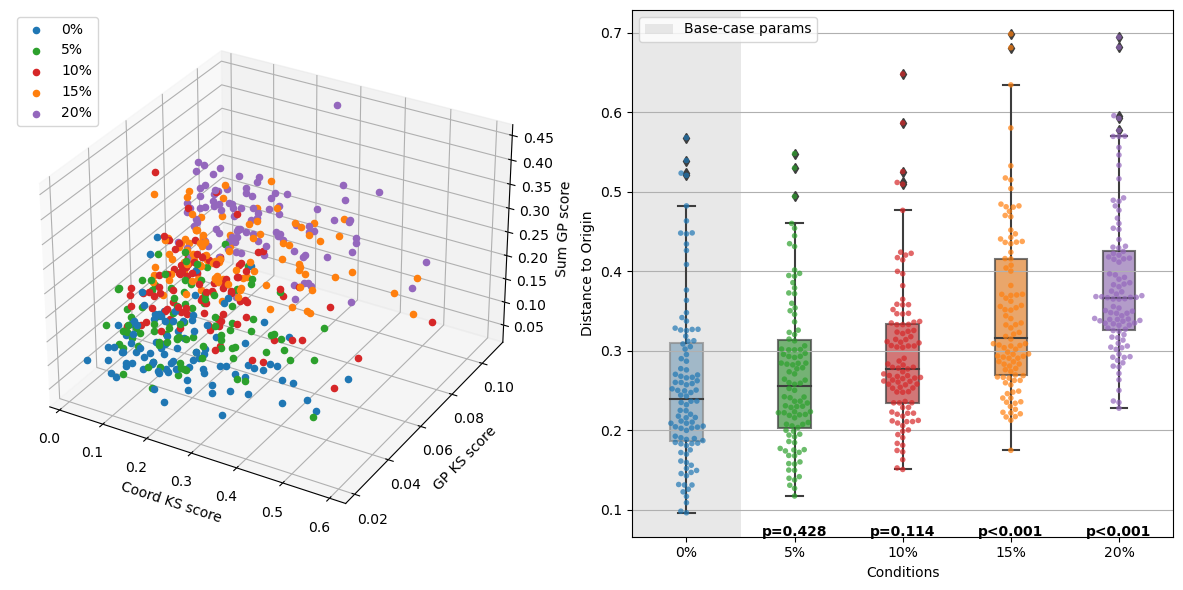

In [13]:
# Function to plot and store results for each condition
def plot_and_store_results(ax, condition_name, all_data, comparison_results, base_data):
    # Create a dictionary to store the results
    comparison_results_cond = {}
    num_datasets = len(all_data)

    # Define color for the condition
    condition_color = None
    if condition_name == '0%':
        condition_color = '#1f77b4'
    elif condition_name == '5%':
        condition_color = '#2ca02c'
    elif condition_name == '10%':
        condition_color = '#d62728'
    elif condition_name == '15%':
        condition_color = '#ff7f0e'
    elif condition_name == '20%':
        condition_color = '#9467bd'

    # Plot all datasets for the gp_tot_ks_similarity
    for i in range(num_datasets):
        dataset = all_data[i]

        # Call comparison function for the data in all_data with the base data
        # Using my method
        result = gp_tot_ks_similarity(base_data, dataset)

        # Plot the result in 3D space'#1f77b4'
        ax.scatter(result[0], result[1], result[2], marker='o', c=condition_color, label=condition_name if i == 0 else "")

        # Store result in dictionary
        comparison_results_cond[i] = result
    
    return comparison_results_cond


# Create figure to plot points in 3D space
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')

# Simulations for Condition 1
all_data_cond1 = [simulate_data_reshuffled(20, 30, 70, 0.5, False, 0.5, 0.25, -0.5, 0.25, 0.0) for _ in range(100)]
#save_simulation_data('ppc_condition2', all_data_cond2)
comparison_results1 = plot_and_store_results(ax, '0%', all_data_cond1, {}, data_base)

# Simulations for Condition 2
all_data_cond2 = [simulate_data_reshuffled(20, 30, 70, 0.5, False, 0.5 , 0.25, -0.5, 0.25, 0.05) for _ in range(100)]
#save_simulation_data('ppc_condition1', all_data_cond1)
comparison_results2 = plot_and_store_results(ax, '5%', all_data_cond2, {}, data_base)

# Simulation for condition 3
all_data_cond3 = [simulate_data_reshuffled(20, 30, 70, 0.5, False, 0.5, 0.25, -0.5, 0.25, 0.10) for _ in range(100)]
comparison_results3 = plot_and_store_results(ax, '10%', all_data_cond3, {}, data_base)

# Simulation for condition 4
all_data_cond4 = [simulate_data_reshuffled(20, 30, 70, 0.5, False, 0.5, 0.25, -0.5, 0.25, 0.15) for _ in range(100)]
comparison_results4 = plot_and_store_results(ax, '15%', all_data_cond4, {}, data_base)

# Simulation for condition 5
all_data_cond5 = [simulate_data_reshuffled(20, 30, 70, 0.5, False, 0.5, 0.25, -0.5, 0.25, 0.20) for _ in range(100)]
comparison_results5 = plot_and_store_results(ax, '20%', all_data_cond5, {}, data_base)

# Set axis labels
ax.set_xlabel('Coord KS score')
ax.set_ylabel('GP KS score')
ax.set_zlabel('Sum GP score')
# Add legend
ax.legend(loc = 'upper left')

# Extract data for each condition
data_conditions = [all_data_cond1, all_data_cond2, all_data_cond3, all_data_cond4, all_data_cond5]
data_comparison = [comparison_results1, comparison_results2, comparison_results3, comparison_results4, comparison_results5]

distances = []
for comparison_result in data_comparison:
    condition_distances = []
    for i in range(len(comparison_result)):
        result = comparison_result[i]
        point_coords = np.array(result)
        distance = distance_to_origin(point_coords)
        condition_distances.append(distance)
    distances.append(condition_distances)

# Compute p-values for each condition compared to 0% reshuffled points
p_values_cond1_vs_others = perform_comparisons(distances, 100, 100, 0)  

# Convert the distances to a DataFrame for plotting
df_distances = pd.DataFrame(distances).transpose()
condition_names = ['0%', '5%', '10%', '15%','20%']
df_distances.columns = condition_names


# Plot the swarm plot with specified colors for each condition
colors = ['#1f77b4', '#2ca02c', '#d62728', '#ff7f0e', '#9467bd'] 

# Plot swarm plot
ax1 = fig.add_subplot(122)
ax1.grid(axis='y')

# Swarm plot
sns.swarmplot(data=df_distances, palette=colors, size=4, alpha=0.7, ax=ax1)

# Overlay box plot (showing median and quartiles)
sns.boxplot(ax=ax1, data=df_distances, palette=colors, width=0.3, boxprops=dict(alpha=0.7))

# Add p-values as annotations under each box plot
# Add p-values as annotations under each box plot
for i, p in enumerate(p_values_cond1_vs_others):
    if i == 0 :
        continue
    else:
        if p < 0.001:
            ax1.text(i, df_distances.min().min() * 0.7, f"p<{1e-3}", horizontalalignment='center', weight='bold')
        elif p < 0.01:
            ax1.text(i, df_distances.min().min() * 0.7, f"p<{1e-2}", horizontalalignment='center', weight='bold')
        elif p < 0.05:  
            ax1.text(i, df_distances.min().min() * 0.7, f"p<{5e-2}", horizontalalignment='center', weight='bold')
        else:
            ax1.text(i, df_distances.min().min() * 0.7, f"p={p}", horizontalalignment='center', weight='bold')

# Find the index range for all_data_cond1
cond1_start = -0.5
cond1_end = 0.5

# Lightly shade the region behind all_data_cond1
ax1.axvspan(cond1_start, cond1_end, facecolor='lightgrey', alpha=0.5, label='Base-case params')

# Set axis labels for swarm plot
ax1.set_xlabel('Conditions')
ax1.set_ylabel('Distance to Origin')
ax1.legend(loc = 'upper left')
fig.tight_layout()

#saving the figure in the file
plt.savefig(os.path.join(folder_name, 'reshuffled_GP_points_smaller_range.png'))
plt.show()

### 4. Applying Method to Experimental Data <a id="applyingmethod"></a>

#### Importing Modules <a id="importingmodules-4"></a>


In [14]:
# %matplotlib notebook
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import norm, ks_2samp
import smlm
import pandas as pd
from smlm.similarity import ks_similarity,freq_hist,_hist_bins
import math
from numpy.typing import ArrayLike
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pstats
import os
from itertools import combinations

#### Defining Functions <a id="definingfunctions-4"></a>

In [15]:
# Create a function to make the Sum of GP values histograms to be used in the KS test 
def gp_freq_hist(coordinates: np.ndarray, gp_values: np.ndarray, bin_size: float = 30.) -> np.ndarray:
    """Calculates a 1D histogram for the sum of gp values within a binned grid.

    Parameters
    ----------
    coordinates
        2D array containing xy coordinates of detections.
    gp_values
        1D array containing gp values corresponding to tissue characteristics.
    bin_size
        Size of bins (for the coordinates) in the same units as coordinates specified by data.

    Returns
    -------
    numpy.ndarray
        Histogram for the sum of gp values per pixel of the binned image.
    int
        minimum integer bin edge for GP sums
    int 
        maximum integer bin edge for GP sum 
    """
    # Bins for image / 2D histogram
    bins = [_hist_bins(coordinates[:, 0], bin_size),
            _hist_bins(coordinates[:, 1], bin_size)]
    
    # Create empty array to store sum of GP values for each bin
    gp_sums = np.zeros((len(bins[0]) - 1, len(bins[1]) - 1))

    # Iterate over each bin
    for i in range(len(bins[0]) - 1):
        for j in range(len(bins[1]) - 1):
            # Find points within the current bin
            points_in_bin = (coordinates[:, 0] >= bins[0][i]) & (coordinates[:, 0] < bins[0][i+1]) & \
                            (coordinates[:, 1] >= bins[1][j]) & (coordinates[:, 1] < bins[1][j+1])
            # Sum GP values of points in the bin
            gp_sum = np.sum(gp_values[points_in_bin])
            # Store the sum in the corresponding position in the array
            gp_sums[i, j] = gp_sum
    
    #flatten gp_sums
    gp_sums = gp_sums.flatten()
    
    # Now that we have binned the values in space we want to bin them in terms of their GP sums 
    # Define the bins for the histogram such that the bin edges are itegers
    min_gp_sum = np.floor(np.min(gp_sums))
    #print(min_gp_sum)
    max_gp_sum = np.ceil(np.max(gp_sums))
    #print(max_gp_sum)
    num_bins = int(max_gp_sum - min_gp_sum) * 2
    
    # Compute the histogram
    gp_hist, bin_edges = np.histogram(gp_sums, bins=num_bins, range=(min_gp_sum, max_gp_sum)) 
    
    # return counts of the GP value sums in each bin 
    return gp_hist, min_gp_sum, max_gp_sum

In [16]:
# Create a function to return the 2-sample KS statistic for the sum of GP values distributions
def gp_ks_similarity(gp_hists: [np.ndarray, np.ndarray], min_gp_sums: ArrayLike, max_gp_sums: ArrayLike, norm: bool = False, alpha: float = 0.05) -> float:

    """Calculates the Kolmogorov-Smirnov (KS) similarity metric for gp values.

    Parameters
    ----------
    gp_hists
        Tuple containing two histograms for comparison (sum of gp values).
    norm
        Should normalization mode to account for offsets in intensity be used.

    Returns
    -------
    float
        The 2-sample Kolmogorov-Smirnov (KS) dissimilarity metric.
    """
    
    assert len(gp_hists) == 2, "Two histograms are required for comparison."

    # Calculate cumulative histograms
    gp_hist_cum = [np.cumsum(hist) for hist in gp_hists]
    
    # Extend the cumulative histogram for comparison
    # Calculate padding for the lower bound
    big_min = max(min_gp_sums[0], min_gp_sums[1])
    small_min = min(min_gp_sums[0], min_gp_sums[1])
    min_pad_range = int(big_min - small_min)
    min_pad_bins = min_pad_range * 2
    #print('min_pad_range', min_pad_range)
    # Calculate padding for the upper bound
    big_max = max(max_gp_sums[0], max_gp_sums[1])
    small_max = min(max_gp_sums[0], max_gp_sums[1])
    max_pad_range = int(big_max - small_max)
    max_pad_bins = max_pad_range * 2
    #print('max_pad_range', max_pad_range)

    if min_pad_range != 0:
        # Pad samples accordingly 
        if min_gp_sums[1] == small_min:
            # then we want to pad gp_hist_cum[0]
            gp_hist_cum[0] = np.pad(gp_hist_cum[0] , (min_pad_bins, 0), mode='constant', constant_values=(0,))
        else:
            # pad gp_hist_cum[1]
            gp_hist_cum[1] = np.pad(gp_hist_cum[1] , (min_pad_bins, 0), mode='constant', constant_values=(0,))

    if max_pad_range != 0:
        # Pad both samples accordingly above
        if max_gp_sums[1] == big_max:
            # then we want to pad gp_hist_cum[0]
            gp_hist_cum[0] = np.pad(gp_hist_cum[0], (0, max_pad_bins), mode='constant', constant_values=(max(gp_hist_cum[0]),))
        else:
            # pad gp_hist_cum[1]
            gp_hist_cum[1] = np.pad(gp_hist_cum[1], (0, max_pad_bins), mode='constant', constant_values=(max(gp_hist_cum[1]),))
    
    # Find sample sizes
    sample_size = [hist[-1] for hist in gp_hist_cum]
    
    # Calculate KS metric using normalised cumulative histograms
    mf = np.max(np.abs(gp_hist_cum[0] / sample_size[0] - gp_hist_cum[1] / sample_size[1]))
    J = (sample_size[0] + sample_size[1]) / (sample_size[0] * sample_size[1])
    c = math.sqrt(-math.log(0.05 / 2) / 2)

    # use the large sample approximation
    return(mf / math.sqrt(J) / c)

In [17]:
# Create a function which calculates all 3 KS scores for space, GP distribution, and sum of GP distribution
def gp_tot_ks_similarity(dataset1: np.ndarray, dataset2: np.ndarray, bin_size: float = 30.0, fov_size: float = 3000.0) -> tuple:
    """
    Calculates three Kolmogorov-Smirnov (KS) scores comparing two datasets.

    The function computes the following KS scores:
    - x-coordinate: KS-score for spatial coordinates only.
    - y-coordinate: KS-score for GP values only.
    - z-coordinate: KS-score for summed GP values in each bin.

    Parameters
    ----------
    dataset1 : np.ndarray
        The first dataset, where the last column contains GP values.
    dataset2 : np.ndarray
        The second dataset, where the last column contains GP values.
    bin_size : float, optional
        The size of the bins used for histogram calculations (default is 30.0).
    fov_size : float, optional
        The field of view size used for histogram calculations (default is 3000.0).

    Returns
    -------
    tuple
        A tuple containing:
        - x_ks : float
            The KS-score for spatial coordinates.
        - y_ks : float
            The KS-score for GP values.
        - z_ks : float
            The KS-score for summed GP values in each bin.
        - mean_ks : float
            The average of the three KS-scores.
    """
    
    # Calculate the KS-score for the coordinates only
    xhist1 = freq_hist(dataset1[:, :2], bin_size, fov_size)
    xhist2 = freq_hist(dataset2[:, :2], bin_size, fov_size)
    x_ks = ks_similarity((xhist1, xhist2))
    
    # Calculate the KS-score for GP values only
    y_ks = ks_2samp(dataset1[:, 2], dataset2[:, 2])[0]
    
    # Calculate the KS-score for the summed GP values
    zhist1, min_gp_sum1, max_gp_sum1 = gp_freq_hist(dataset1[:, :2], dataset1[:, 2], bin_size)
    zhist2, min_gp_sum2, max_gp_sum2 = gp_freq_hist(dataset2[:, :2], dataset2[:, 2], bin_size)
    z_ks = gp_ks_similarity((zhist1, zhist2), [min_gp_sum1, min_gp_sum2], [max_gp_sum1, max_gp_sum2])
    
    # Compute the mean of the KS-scores
    mean_ks = np.mean([x_ks, y_ks, z_ks])
    
    return x_ks, y_ks, z_ks, mean_ks


In [18]:
# Create a function which calculates all 3 KS scores for space, GP distribution, and sum of GP distribution
def gp_tot_ks_similarity(dataset1: np.ndarray, dataset2: np.ndarray, bin_size: float = 30.0, fov_size: float = 3000.0) -> tuple:
    """
    Calculates three Kolmogorov-Smirnov (KS) scores comparing two datasets.

    The function computes the following KS scores:
    - x-coordinate: KS-score for spatial coordinates only.
    - y-coordinate: KS-score for GP values only.
    - z-coordinate: KS-score for summed GP values in each bin.

    Parameters
    ----------
    dataset1 : np.ndarray
        The first dataset, where the last column contains GP values.
    dataset2 : np.ndarray
        The second dataset, where the last column contains GP values.
    bin_size : float, optional
        The size of the bins used for histogram calculations (default is 30.0).
    fov_size : float, optional
        The field of view size used for histogram calculations (default is 3000.0).

    Returns
    -------
    tuple
        A tuple containing:
        - x_ks : float
            The KS-score for spatial coordinates.
        - y_ks : float
            The KS-score for GP values.
        - z_ks : float
            The KS-score for summed GP values in each bin.
        - mean_ks : float
            The average of the three KS-scores.
    """
    
    # Calculate the KS-score for the coordinates only
    xhist1 = freq_hist(dataset1[:, :2], bin_size, fov_size)
    xhist2 = freq_hist(dataset2[:, :2], bin_size, fov_size)
    x_ks = ks_similarity((xhist1, xhist2))
    
    # Calculate the KS-score for GP values only
    y_ks = ks_2samp(dataset1[:, 2], dataset2[:, 2])[0]
    
    # Calculate the KS-score for the summed GP values
    zhist1, min_gp_sum1, max_gp_sum1 = gp_freq_hist(dataset1[:, :2], dataset1[:, 2], bin_size)
    zhist2, min_gp_sum2, max_gp_sum2 = gp_freq_hist(dataset2[:, :2], dataset2[:, 2], bin_size)
    z_ks = gp_ks_similarity((zhist1, zhist2), [min_gp_sum1, min_gp_sum2], [max_gp_sum1, max_gp_sum2])
    
    # Compute the mean of the KS-scores
    mean_ks = np.mean([x_ks, y_ks, z_ks])
    
    return x_ks, y_ks, z_ks, mean_ks


In [19]:
# Create a function that calculates the distance to the origin of a point in 3D space
def distance_to_origin(point_coords: np.ndarray) -> float:
    """
    Calculates the Euclidean distance from a point in 3D space to the origin.

    Parameters
    ----------
    point_coords : np.ndarray
        A 1D array or list with three elements representing the coordinates of the point in 3D space.

    Returns
    -------
    float
        The Euclidean distance from the point to the origin.
    """
    
    # Ensure the input is a numpy array
    point_coords = np.asarray(point_coords)
    
    # Compute the Euclidean distance to the origin
    return math.sqrt(np.sum(np.square(point_coords)))

In [20]:
# Create a function to simulate marked SMLM
def simulate_data(n: int, p: int, sigma: float, background_density: float, plot: bool,
                  GP_mean_c: float, GP_st_dev_c: float, GP_mean_b: float, GP_st_dev_b: float) -> np.ndarray:
    """
    Simulates data of clustered and background points with Gaussian distributions.

    This function generates `n` clusters, each with `p` points, distributed according to a Gaussian distribution with standard deviation `sigma`.
    Background points are added based on a density `background_denity`, with GP values also generated for these points.

    Parameters
    ----------
    n : int
        The number of clusters.
    p : int
        The number of points per cluster.
    sigma : float
        The standard deviation of the Gaussian distribution for the clusters.
    background_density : float
        The fraction of total points that are background points.
    plot : bool
        If True, plots the point distributions and GP values.
    GP_mean_c : float
        The mean of the GP distribution for clustered points.
    GP_st_dev_c : float
        The standard deviation of the GP distribution for clustered points.
    GP_mean_b : float
        The mean of the GP distribution for background points.
    GP_st_dev_b : float
        The standard deviation of the GP distribution for background points.

    Returns
    -------
    np.ndarray
        An array of simulated data points with corresponding GP values.
    """

    # Generate clustered points
    n_samples = p * n
    n_blobs = n
    X, y_true = make_blobs(
        n_samples=n_samples, centers=n_blobs, cluster_std=sigma, center_box=(0, 3000.0))
    X = X[:, ::-1]  # Swap columns for plotting

    # Initialize matrix to store clustered points with GP values
    X_values_c = np.empty((0, 2))

    # Process each cluster
    for k in range(n_blobs):
        cluster_data = y_true == k
        cluster_values = X[cluster_data, :2]
        X_values_c = np.vstack((X_values_c, cluster_values))

    # Generate GP values for clustered points
    GP_cluster = generate_GP_vals(n_samples, GP_mean_c, GP_st_dev_c)
    X_values_c = np.column_stack((X_values_c, GP_cluster))

    # Generate background points
    p_background = int(n_samples * background_density)
    xlist = np.random.uniform(low=0, high=3000, size=p_background)
    ylist = np.random.uniform(low=0, high=3000, size=p_background)
    X_values_b = np.column_stack((xlist, ylist))

    # Generate GP values for background points
    GP_background = generate_GP_vals(p_background, GP_mean_b, GP_st_dev_b)
    X_values_b = np.column_stack((X_values_b, GP_background))

    # Plot distributions if requested
    if plot:
        plt.figure(figsize=(10, 5))
        
        # Subplot 1: Point Distribution
        plt.subplot(1, 2, 1)
        for k in range(n_blobs):
            cluster_data = y_true == k
            plt.scatter(X[cluster_data, 0], X[cluster_data, 1], marker=".", color='#440154FF')
        plt.scatter(xlist, ylist, marker=".", color='#7AD151FF', label='Background Points')
        plt.title('Point Distribution')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.xlim(0, 3000)
        plt.ylim(0, 3000)
        
        # Subplot 2: GP Values Distribution
        plt.subplot(1, 2, 2)
        plt.hist(GP_cluster, bins=20, density=False, alpha=0.7, color='#440154FF', label='Clustered GP')
        plt.hist(GP_background, bins=20, density=False, alpha=0.7, color='#7AD151FF', label='Background GP')
        plt.title('GP Distribution')
        plt.xlabel('GP')
        plt.ylabel('Frequency')
        plt.legend(loc='best')

    # Combine clustered and background point coordinates
    sim_values = np.vstack((X_values_c, X_values_b))

    return sim_values


In [21]:
def pairwise_comparison(ax, control_data: list, mbcd_data: list) -> dict:
    """
    Performs pairwise comparisons between Control and MBCD datasets and visualizes the results 
    using 3D scatter plots. The comparisons include Control vs Control, MBCD vs MBCD, and MBCD 
    vs Control.

    Parameters
    ----------
    ax : matplotlib.axes._subplots.Axes3DSubplot
        A 3D axis object on which to plot the scatter plots.
    control_data : list
        A list of numpy arrays containing Control data.
    mbcd_data : list
        A list of numpy arrays containing MBCD data.

    Returns
    -------
    dict
        A dictionary containing the pairwise comparison results categorized into three keys:
        'Control_vs_Control', 'MBCD_vs_MBCD', and 'MBCD_vs_Control'. Each key holds a list 
        of results from the comparison function.
    """
    # Dictionary to store comparison results
    comparison_results = {'Control_vs_Control': [], 'MBCD_vs_MBCD': [], 'MBCD_vs_Control': []}
    
    # Define colors for the scatter plots
    colors = ['#21918c', '#5ec962', 'mediumpurple']  # Colors: Control vs Control, MBCD vs MBCD, MBCD vs Control
    
    # Perform MBCD vs Control comparison and plot results
    k = 0
    for control_set in control_data:
        for mbcd_set in mbcd_data:
            # Perform the comparison using a custom similarity function (gp_tot_ks_similarity)
            result_mbcd_vs_control = gp_tot_ks_similarity(mbcd_set, control_set)
            comparison_results['MBCD_vs_Control'].append(result_mbcd_vs_control)
            
            # Plot the result in the 3D space
            ax.scatter(result_mbcd_vs_control[0], result_mbcd_vs_control[1], result_mbcd_vs_control[2], 
                       marker='o', color=colors[2], s=3, label='MBCD vs Control' if k == 0 else "")
            k += 1

    # Perform MBCD vs MBCD comparisons and plot results
    j = 0
    for dataset1, dataset2 in combinations(mbcd_data, 2):
        result_mbcd_vs_mbcd = gp_tot_ks_similarity(dataset1, dataset2)
        comparison_results['MBCD_vs_MBCD'].append(result_mbcd_vs_mbcd)
        
        # Plot the result in the 3D space
        ax.scatter(result_mbcd_vs_mbcd[0], result_mbcd_vs_mbcd[1], result_mbcd_vs_mbcd[2], 
                   marker='o', color=colors[1], s=3, label='MBCD vs MBCD' if j == 0 else "")
        j += 1
    
    # Perform Control vs Control comparisons and plot results
    i = 0
    for dataset1, dataset2 in combinations(control_data, 2):
        result_control_vs_control = gp_tot_ks_similarity(dataset1, dataset2)
        comparison_results['Control_vs_Control'].append(result_control_vs_control)
        
        # Plot the result in the 3D space
        ax.scatter(result_control_vs_control[0], result_control_vs_control[1], result_control_vs_control[2], 
                   marker='o', color=colors[0], s=3, label='Control vs Control' if i == 0 else "")
        i += 1

    return comparison_results

In [22]:
def sim(n: int, m: int, mu: float = 0, X: np.ndarray = None, Y: np.ndarray = None) -> np.ndarray:
    """
    Simulates a distance matrix based on the given points X and Y.

    Parameters
    ----------
    n : int
        The number of points in dataset X.
    m : int
        The number of points in dataset Y.
    mu : float, optional
        A parameter to adjust the similarity function (default is 0).
    X : np.ndarray, optional
        Array of shape (n,) representing dataset X.
    Y : np.ndarray, optional
        Array of shape (m,) representing dataset Y.

    Returns
    -------
    np.ndarray
        The distance matrix of shape (n + m, n + m).
    
    Raises
    ------
    ValueError
        If X or Y is None.
    """
    if X is None or Y is None:
        raise ValueError("X and Y must be provided")
    
    Z = np.concatenate((X, Y))

    # Calculate the distance matrix
    D = np.zeros((n + m, n + m))
    for i in range(n + m):
        for j in range(n + m):
            D[i, j] = 1 - np.exp(-0.5 * (Z[i] - Z[j])**2)
    
    return D

def test_statistic(D: np.ndarray, n: int, m: int) -> float:
    """
    Calculates the test statistic for the given distance matrix.

    Parameters
    ----------
    D : np.ndarray
        The distance matrix of shape (n + m, n + m).
    n : int
        The number of points in dataset X.
    m : int
        The number of points in dataset Y.

    Returns
    -------
    float
        The test statistic.
    """
    t1 = np.sum(D[:n, n:n+m]) / (n * m)
    t2 = np.sum(D[:n, :n]) / (n * (n - 1))
    t3 = np.sum(D[n:n+m, n:n+m]) / (m * (m - 1))
    return t1 - t2 - t3

def p_value(D: np.ndarray, n: int, m: int) -> float:
    """
    Calculates the p-value for the test statistic based on permutations.

    Parameters
    ----------
    D : np.ndarray
        The distance matrix of shape (n + m, n + m).
    n : int
        The number of points in dataset X.
    m : int
        The number of points in dataset Y.

    Returns
    -------
    float
        The p-value.
    """
    t = test_statistic(D, n, m)
    perm_stats = [test_statistic(D[np.random.permutation(n + m), :][:, np.random.permutation(n + m)], n, m) for _ in range(1000)]
    return np.mean(np.array(perm_stats) >= t)

def perform_comparisons(distances: list, n: int, m: int, base_index: int) -> list:
    """
    Performs statistical comparisons of distances against a base dataset.

    Parameters
    ----------
    distances : list
        List of datasets to compare.
    n : int
        The number of points in each dataset.
    m : int
        The number of points in each dataset.
    base_index : int
        Index of the base dataset for comparisons.

    Returns
    -------
    list
        List of p-values for comparisons with the base dataset.
    """
    p_values_array = []
    
    for i in range(len(distances)):
        if i == base_index:
            p_val = 1.0
        else:
            X = distances[base_index]
            Y = distances[i]
            D = sim(n, m, X=X, Y=Y)
            p_val = p_value(D, n, m)
        p_values_array.append(p_val)
    
    return p_values_array

from itertools import combinations



#### Importing the Data <a id="importdata"></a>

In [23]:
# First we need a little extra functions to run this smoothly

def extract_csv_files(directory: str) -> list:
    """
    Extracts CSV files from the given directory, excluding files that end with '_pts_per_ROI.csv'.

    Parameters
    ----------
    directory : str
        The directory from which to extract the CSV files.

    Returns
    -------
    list
        A list of file paths for CSV files in the directory, excluding files with names ending in '_pts_per_ROI.csv'.
    """
    csv_files = []
    
    # Walk through the directory to find all files
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Check if the file is a CSV and does not end with '_pts_per_ROI.csv'
            if file.endswith('.csv') and not file.endswith('_pts_per_ROI.csv'):
                csv_files.append(os.path.join(root, file))  # Add the valid file path to the list

    return csv_files

def read_csv_and_extract_data(csv_files: list) -> dict:
    """
    Reads CSV files and extracts the relevant data ('x [nm]', 'y [nm]', and 'GP') from them. 
    The data is categorized into 'Control' and 'MBCD' based on the file names.

    Parameters
    ----------
    csv_files : list
        A list of CSV file paths to be processed.

    Returns
    -------
    dict
        A dictionary with two keys: 'Control' and 'MBCD', each containing a list of numpy arrays with
        the extracted data for the respective type.
    """
    control_data = []
    mbcd_data = []

    # Iterate over each CSV file
    for file in csv_files:
        try:
            # Try reading the CSV file using UTF-8 encoding
            df = pd.read_csv(file, encoding='utf-8')
        except UnicodeDecodeError:
            # If a UnicodeDecodeError occurs, attempt to read using Latin-1 encoding
            print(f"UnicodeDecodeError: Unable to read file {file} with UTF-8 encoding. Trying Latin-1 encoding.")
            df = pd.read_csv(file, encoding='latin-1')

        # Check if the required columns are present in the DataFrame
        if 'x [nm]' in df.columns and 'y [nm]' in df.columns and 'GP' in df.columns:
            # Extracting 'x [nm]', 'y [nm]', and 'GP' column data
            x_data = df['x [nm]'].tolist()
            y_data = df['y [nm]'].tolist()
            GP_data = df['GP'].tolist()

            # Combine the extracted columns into a 2D array
            data = np.column_stack((x_data, y_data, GP_data))

            # Determine the data type based on the filename (either 'Control' or 'MBCD')
            data_type = 'MBCD' if 'MBCD' in file else 'Control'

            # Store the data in the appropriate list based on its type
            if data_type == 'Control':
                control_data.append(data)
            else:
                mbcd_data.append(data)
        else:
            # Print a warning if the required columns are not found in the CSV file
            print(f"Required columns not found in file: {file}")

    # Return the extracted data categorized into 'Control' and 'MBCD'
    return {'Control': control_data, 'MBCD': mbcd_data}

# Define the directory path
base_dir = 'Dan_data'

# Extract CSV files from new_GP_data_SET2
set2_dir = os.path.join(base_dir, 'new_GP_data_SET2', 'new_GP_data_SET2')
set2_csv_files = extract_csv_files(set2_dir)
set2_data = read_csv_and_extract_data(set2_csv_files)

# Extract CSV files from new_GP_data_SET1+3
set1_3_dir = os.path.join(base_dir, 'new_GP_data_SET1+3', 'new_GP_data_SET1+3')
set1_3_csv_files = extract_csv_files(set1_3_dir)
set1_3_data = read_csv_and_extract_data(set1_3_csv_files)

# Merge control and MBCD data from both sets
control_data = set1_3_data['Control'] + set2_data['Control']
mbcd_data = set1_3_data['MBCD'] + set2_data['MBCD']

#### Apply Method to Data <a id="applymethod"></a>


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


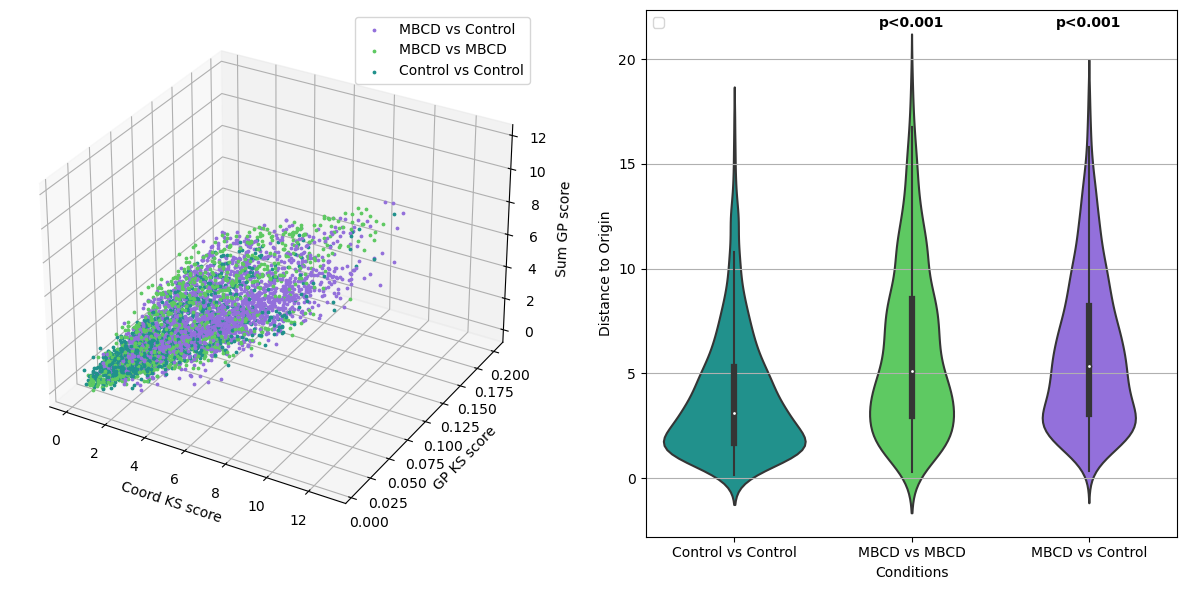

In [24]:
# Define a folder name in which the figure will be saved
folder_name = 'Experimental Data Figure'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
 
# Create figure to plot points in 3D space
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')

# Perform pairwise comparison
comparison_results = pairwise_comparison(ax, control_data, mbcd_data)

# Set axis labels
ax.set_xlabel('Coord KS score')
ax.set_ylabel('GP KS score')
ax.set_zlabel('Sum GP score')

# Add legend
ax.legend()

# Extracting results for Control vs Control comparisons
control_vs_control_results = comparison_results['Control_vs_Control']

# Extracting results for MBCD vs MBCD comparisons
mbcd_vs_mbcd_results = comparison_results['MBCD_vs_MBCD']

# Extracting results for MBCD vs Control comparisons
mbcd_vs_control_results = comparison_results['MBCD_vs_Control']

# Calculate distances for Control vs Control comparisons
distances_control_vs_control = []
for result in control_vs_control_results:
    point_coords = np.array(result)
    distance = distance_to_origin(point_coords)
    distances_control_vs_control.append(distance)

# Calculate distances for MBCD vs MBCD comparisons
distances_mbcd_vs_mbcd = []
for result in mbcd_vs_mbcd_results:
    point_coords = np.array(result)
    distance = distance_to_origin(point_coords)
    distances_mbcd_vs_mbcd.append(distance)

# Calculate distances for MBCD vs Control comparisons
distances_mbcd_vs_control = []
for result in mbcd_vs_control_results:
    point_coords = np.array(result)
    distance = distance_to_origin(point_coords)
    distances_mbcd_vs_control.append(distance)
    
# Combine all distances
distances = [distances_control_vs_control, distances_mbcd_vs_mbcd, distances_mbcd_vs_control]
distances1 = [distances_control_vs_control, distances_control_vs_control]
distances2 = [distances_mbcd_vs_mbcd, distances_control_vs_control]
distances3 = [distances_mbcd_vs_control, distances_control_vs_control]

# Compute p-values for each condition compared to Control vs Control
p_value_1 = perform_comparisons(distances1, len(distances_control_vs_control), len(distances_control_vs_control), 1)
p_value_2 = perform_comparisons(distances2, len(distances_mbcd_vs_mbcd), len(distances_control_vs_control), 1)
p_value_3 = perform_comparisons(distances3, len(distances_mbcd_vs_control), len(distances_control_vs_control), 1)

# Convert the distances to a DataFrame for plotting
df_distances = pd.DataFrame(distances).transpose()
condition_names = ['Control vs Control', 'MBCD vs MBCD','MBCD vs Control']
df_distances.columns = condition_names

# Compute p-values for each condition compared to 20 clusters
p_values_cc_vs_others = [p_value_1[1], p_value_2[0], p_value_3[0]]

# Define the new colors for violin plot
colors = ['#21918c', '#5ec962', 'mediumpurple']

# Plot swarm plot
ax1 = fig.add_subplot(122)
ax1.grid(axis='y')

# Violin plot
violins = sns.violinplot(data=distances, palette=colors, ax=ax1, alpha=0.5)

# Set violin colors
for violin, color in zip(violins.collections[::2], colors):  # Use collections to access the violin parts
    violin.set_facecolor(color)

# Add p-values as annotations above each violin plot
for i, p in enumerate(p_values_cc_vs_others):
    if i == 0 :
        continue
    else:
        if p < 0.001:
            ax1.text(i, df_distances.max().max() * 1.12, f"p<{1e-3}", horizontalalignment='center', weight='bold')
        elif p < 0.01:
            ax1.text(i, df_distances.max().max() * 1.12, f"p<{1e-2}", horizontalalignment='center', weight='bold')
        elif p < 0.05:  
            ax1.text(i, df_distances.max().max() * 1.12, f"p<{5e-2}", horizontalalignment='center', weight='bold')
        else:
            ax1.text(i, df_distances.max().max() * 1.12, f"p={p}", horizontalalignment='center', weight='bold')
            
# Set axis labels for violin plot
ax1.set_xlabel('Conditions')
ax1.set_ylabel('Distance to Origin')

# Set x-axis ticks and labels
ax1.set_xticks(np.arange(0, len(condition_names)))
ax1.set_xticklabels(condition_names)

ax1.legend(loc = 'upper left')
fig.tight_layout()

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.2)

# Save the figure
plt.savefig(os.path.join(folder_name, 'experimental_data4.png'))

plt.show()
